## Importing Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import missingno as msno
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, make_scorer, confusion_matrix, f1_score, recall_score, precision_score, log_loss
from sklearn.feature_selection import RFE
from scipy.stats.mstats import winsorize
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import os
from sklearn.model_selection import GridSearchCV, cross_val_score, ShuffleSplit
import pickle
warnings.filterwarnings("ignore")
import scipy.stats as stats
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier

In [4]:
# Load the training dataset from 'Train.csv' into a DataFrame named 'train'
train = pd.read_csv('Train.csv')  
# Display the first 5 rows of the DataFrame to preview the data
train.head(5)  

,user_id,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,MRG,REGULARITY,TOP_PACK,FREQ_TOP_PACK,CHURN
0,dcf68cc2fb515ccad7d8b9b3bd80ee2a4b270063,SAINT-LOUIS,K > 24 month,17000.0,32.0,18000.0,6000.0,34.0,NaN,97.0,355.0,6.0,NaN,NaN,NO,62,All-net 500F=2000F;5d,35.0,0
1,71c44b5ba328db5c4192a80f7cf8f244d9350ed0,NaN,K > 24 month,4300.0,29.0,4427.0,1476.0,37.0,1764.0,8.0,3.0,0.0,NaN,2.0,NO,40,"Data: 100 F=40MB,24H",22.0,0
2,ce46411b1526c94f20a383b8cb188f8d27f82a0a,TAMBACOUNDA,K > 24 month,1500.0,3.0,1500.0,500.0,3.0,NaN,30.0,30.0,NaN,NaN,NaN,NO,32,All-net 500F=2000F;5d,3.0,0
3,f467cdb6669818373c26c2bad44e01ba66f97d21,FATICK,K > 24 month,1500.0,3.0,2497.0,832.0,4.0,0.0,159.0,45.0,19.0,NaN,NaN,NO,18,On net 200F=Unlimited _call24H,3.0,0
4,ec45e1a1888a32b5dcce0954cfec20c6e037db31,FATICK,K > 24 month,NaN,NaN,498.0,166.0,3.0,1.0,1.0,3.0,NaN,NaN,NaN,NO,50,NaN,NaN,0


In [5]:
# Load the out of sample test dataset from 'Train.csv' into a DataFrame named 'test'
test = pd.read_csv('Test.csv')
# Display the first 5 rows of the DataFrame to preview the data
test.head(5)

,user_id,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,MRG,REGULARITY,TOP_PACK,FREQ_TOP_PACK
0,af900d87e73b7ff6509d2203df4704a98aa5f2a6,NaN,K > 24 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,1,NaN,NaN
1,5335efd940280b82143272275637d1e65d37eadb,NaN,K > 24 month,NaN,NaN,10.0,3.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NO,2,NaN,NaN
2,a581f4fa08677c26f83f643248c667e241043086,NaN,K > 24 month,1900.0,15.0,2299.0,766.0,21.0,414.0,NaN,7.0,2.0,NaN,NaN,NO,27,"Data: 100 F=40MB,24H",17.0
3,64f67177d0775262b8087a9e2e3b8061b6324ae6,DAKAR,K > 24 month,3000.0,9.0,2603.0,868.0,14.0,332.0,0.0,23.0,4.0,NaN,NaN,NO,46,IVR Echat_Daily_50F,3.0
4,0d6009a4594c4be22449b8d9cc01a0bcea98faea,DAKAR,K > 24 month,32000.0,47.0,33000.0,11000.0,47.0,NaN,128.0,555.0,280.0,NaN,NaN,NO,61,All-net 500F=2000F;5d,65.0


## Data Summary and Visualization

In [6]:
def summary(df):
    # Print the shape of the DataFrame (rows, columns)
    print(f'data shape: {df.shape}')
    
    # Create a DataFrame to hold the summary information
    summ = pd.DataFrame(df.dtypes, columns=['data type'])  # Column for data types
    
    # Add a column for the number of missing values in each column
    summ['#missing'] = df.isnull().sum().values
    
    # Add a column for the percentage of missing values in each column
    summ['%missing'] = df.isnull().sum().values / len(df) * 100
    
    # Add a column for the number of unique values in each column
    summ['#unique'] = df.nunique().values
    
    # Get descriptive statistics for all columns and transpose the DataFrame
    desc = pd.DataFrame(df.describe(include='all').transpose())
    
    # Add columns from the descriptive statistics to the summary DataFrame
    summ['count'] = desc['count'].values
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    summ['mean'] = desc['mean'].values
    summ['std'] = desc['std'].values
    summ['median'] = desc['50%'].values
    
    # Add the first three values of each column to the summary
    summ['first value'] = df.loc[0].values
    summ['second value'] = df.loc[1].values
    summ['third value'] = df.loc[2].values
    
    # Return the summary DataFrame
    return summ


In [7]:
# Getting a summary of the train dataset using the function created earlier
summary(train)

data shape: (400000, 19)


,data type,#missing,%missing,#unique,count,min,max,mean,std,median,first value,second value,third value
user_id,object,0,0.00000,400000,400000,NaN,NaN,NaN,NaN,NaN,dcf68cc2fb515ccad7d8b9b3bd80ee2a4b270063,71c44b5ba328db5c4192a80f7cf8f244d9350ed0,ce46411b1526c94f20a383b8cb188f8d27f82a0a
REGION,object,157520,39.38000,14,242480,NaN,NaN,NaN,NaN,NaN,SAINT-LOUIS,NaN,TAMBACOUNDA
TENURE,object,0,0.00000,8,400000,NaN,NaN,NaN,NaN,NaN,K > 24 month,K > 24 month,K > 24 month
MONTANT,float64,140277,35.06925,2421,259723.0,20.0,226550.0,5522.971346,7099.64063,3000.0,17000.0,4300.0,1500.0
FREQUENCE_RECH,float64,140277,35.06925,111,259723.0,1.0,133.0,11.503733,13.275514,6.0,32.0,29.0,3.0
REVENUE,float64,134663,33.66575,23760,265337.0,1.0,233413.0,5505.487757,7175.802367,3000.0,18000.0,4427.0,1500.0
ARPU_SEGMENT,float64,134663,33.66575,11014,265337.0,0.0,77804.0,1835.167658,2391.92929,1000.0,6000.0,1476.0,500.0
FREQUENCE,float64,134663,33.66575,91,265337.0,1.0,91.0,13.951835,14.679943,9.0,34.0,37.0,3.0
DATA_VOLUME,float64,196854,49.21350,22229,203146.0,0.0,934576.0,3369.763441,12281.867504,267.0,NaN,1764.0,NaN
ON_NET,float64,145819,36.45475,5996,254181.0,0.0,45011.0,275.917586,873.593034,27.0,97.0,8.0,30.0


<div class="alert alert-block alert-info" >
<b>Inferences</b>
    <p><li>The training dataset has 400,000 rows and 19 columns</li></p>
    <p><li>All except four features has missing values in them, they include the 'user_id' feature, the 'TENURE' feature, the 'MRG' feature, the 'REGULARITY' feature and the 'CHURN' feature</li></p>
    <p><li>The 'ZONE1 and 'ZONE2 features has the most missing or null values</li></p>
    <p><li>The 'MRG' feature has only one unique value in it, it will be dropped later before the modelling phase  </li></p>
</div>

In [8]:
# Getting a summary of the test dataset
summary(test)

data shape: (100000, 18)


,data type,#missing,%missing,#unique,count,min,max,mean,std,median,first value,second value,third value
user_id,object,0,0.000,100000,100000,NaN,NaN,NaN,NaN,NaN,af900d87e73b7ff6509d2203df4704a98aa5f2a6,5335efd940280b82143272275637d1e65d37eadb,a581f4fa08677c26f83f643248c667e241043086
REGION,object,39293,39.293,14,60707,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TENURE,object,0,0.000,8,100000,NaN,NaN,NaN,NaN,NaN,K > 24 month,K > 24 month,K > 24 month
MONTANT,float64,34951,34.951,1269,65049.0,25.0,201500.0,5545.61363,7123.955226,3000.0,NaN,NaN,1900.0
FREQUENCE_RECH,float64,34951,34.951,106,65049.0,1.0,120.0,11.545051,13.27127,7.0,NaN,NaN,15.0
REVENUE,float64,33490,33.490,13625,66510.0,1.0,181135.0,5518.341663,7177.840304,3000.0,NaN,10.0,2299.0
ARPU_SEGMENT,float64,33490,33.490,7277,66510.0,0.0,60378.0,1839.453676,2392.609422,1000.0,NaN,3.0,766.0
FREQUENCE,float64,33490,33.490,91,66510.0,1.0,91.0,13.979973,14.655983,9.0,NaN,1.0,21.0
DATA_VOLUME,float64,49338,49.338,11526,50662.0,0.0,474262.0,3357.428033,10515.256185,268.0,NaN,NaN,414.0
ON_NET,float64,36383,36.383,3488,63617.0,0.0,24887.0,279.370703,870.773904,27.0,NaN,NaN,NaN


## EDA and Data Visualization

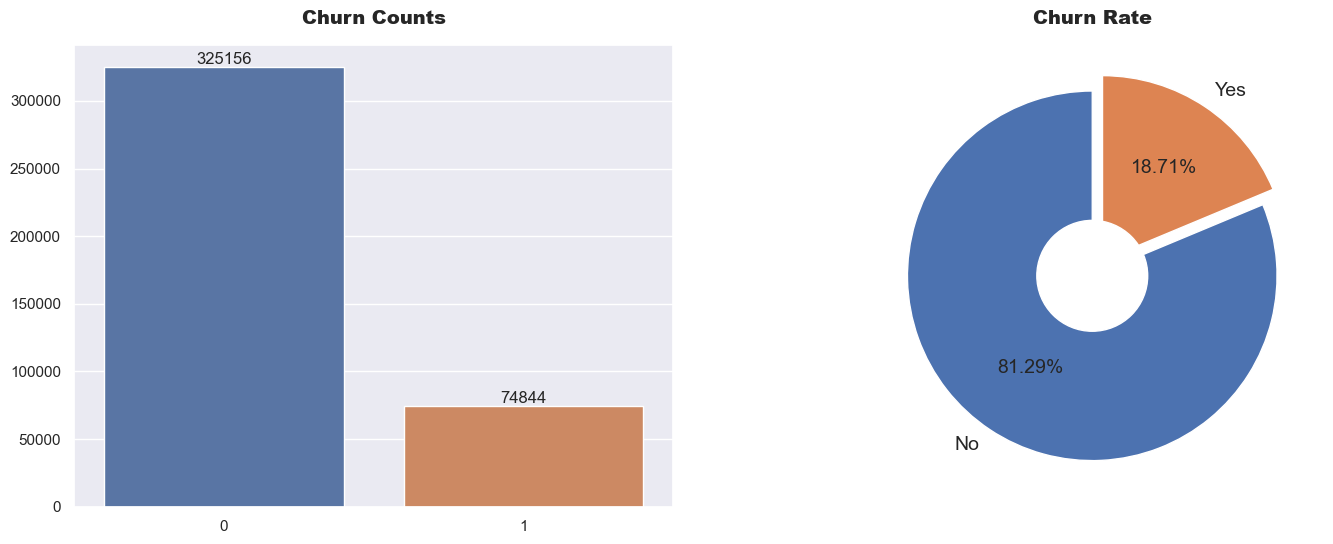

In [9]:
sns.set()  # Set the Seaborn aesthetic parameters for all the following plots

# Visualization to show Churn in Counts
plt.figure(figsize=(17, 6))  # Create a new figure with a specified size

# First subplot: Bar plot of churn counts
plt.subplot(1, 2, 1)  # Set up a 1x2 grid of subplots, this is the first one
churn_rate = train['CHURN'].value_counts()  # Calculate the count of each unique value in the 'CHURN' column
ax = sns.barplot(x=churn_rate.index, y=churn_rate.values)  # Create a bar plot with churn categories on the x-axis and their counts on the y-axis
plt.title("Churn Counts", fontweight="black", size=14, pad=15)  # Set the title for the plot with specific font properties
for container in ax.containers:  # Loop through the containers in the bar plot
    ax.bar_label(container)  # Label each bar with its height (value)

# Second subplot: Pie chart showing churn percentage
plt.subplot(1, 2, 2)  # Move to the second subplot in the 1x2 grid
plt.pie(churn_rate, labels=["No", "Yes"], autopct="%.2f%%", textprops={"size": 14}, explode=[0, 0.1], startangle=90)  
# Create a pie chart with specific labels, percentage format, text size, and an exploded slice for emphasis
center_circle = plt.Circle((0, 0), 0.3, fc='white')  # Create a white circle to simulate a donut chart
fig = plt.gcf()  # Get the current figure
fig.gca().add_artist(center_circle)  # Add the white circle to the pie chart
plt.title("Churn Rate", fontweight="black", size=14, pad=15)  # Set the title for the pie chart
plt.show()  # Display the plots


<div class="alert alert-block alert-info" >
<b>Inferences</b>
    <p><li>The training dataset is highly imbalanced withe the '0' class making up 81.29% and the '1' class making up 18.71%</li></p>
</div>

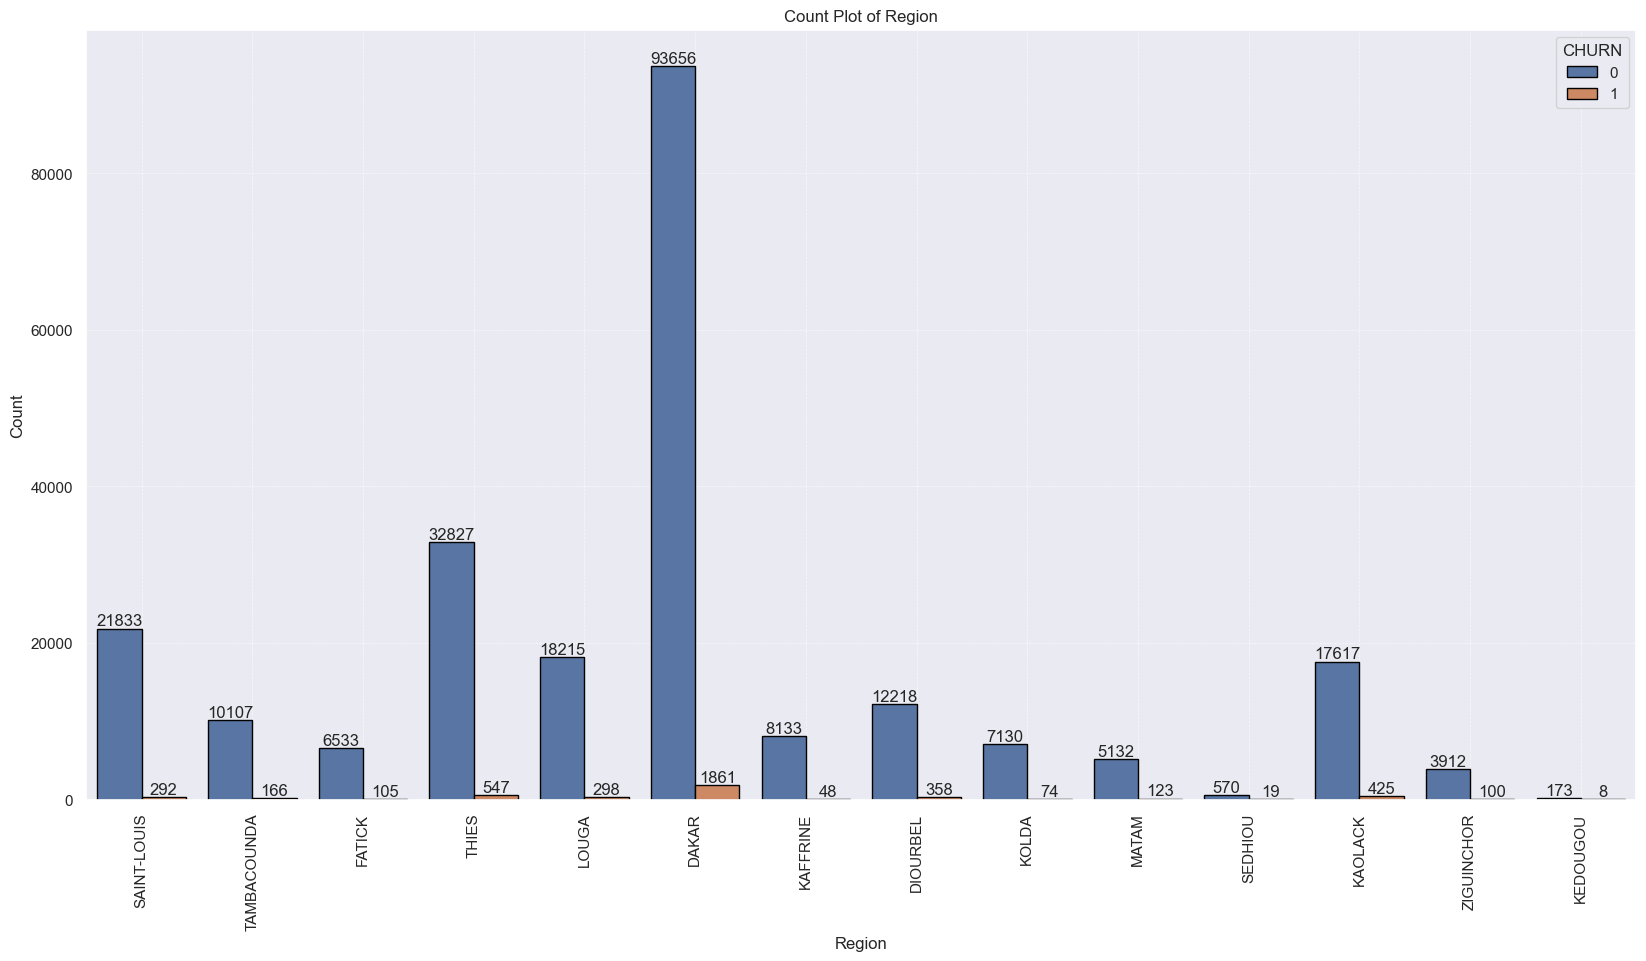

In [10]:
# Visualization of countplot of customers by Region taking into consideration whether they churned or not

plt.figure(figsize=(20, 10))

# Define a color palette with attractive colors
palette = sns.color_palette("Set2")
ax = sns.countplot(data=train, x='REGION', hue='CHURN', edgecolor='black')
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
# Setting the background color
for container in ax.containers:
        ax.bar_label(container)

# Add titles and labels
plt.title(f'Count Plot of Region')
plt.xlabel('Region')
plt.ylabel('Count')
plt.xticks(rotation = 90)
plt.show()

<div class="alert alert-block alert-info" >
<b>Inferences</b>
    <p><li>Most of the customers are from Dakar</li></p>
    <p><li>The kedougou region has the highest churned customers to non-churned customers ratio</li></p>
</div>

<Figure size 2000x2000 with 0 Axes>

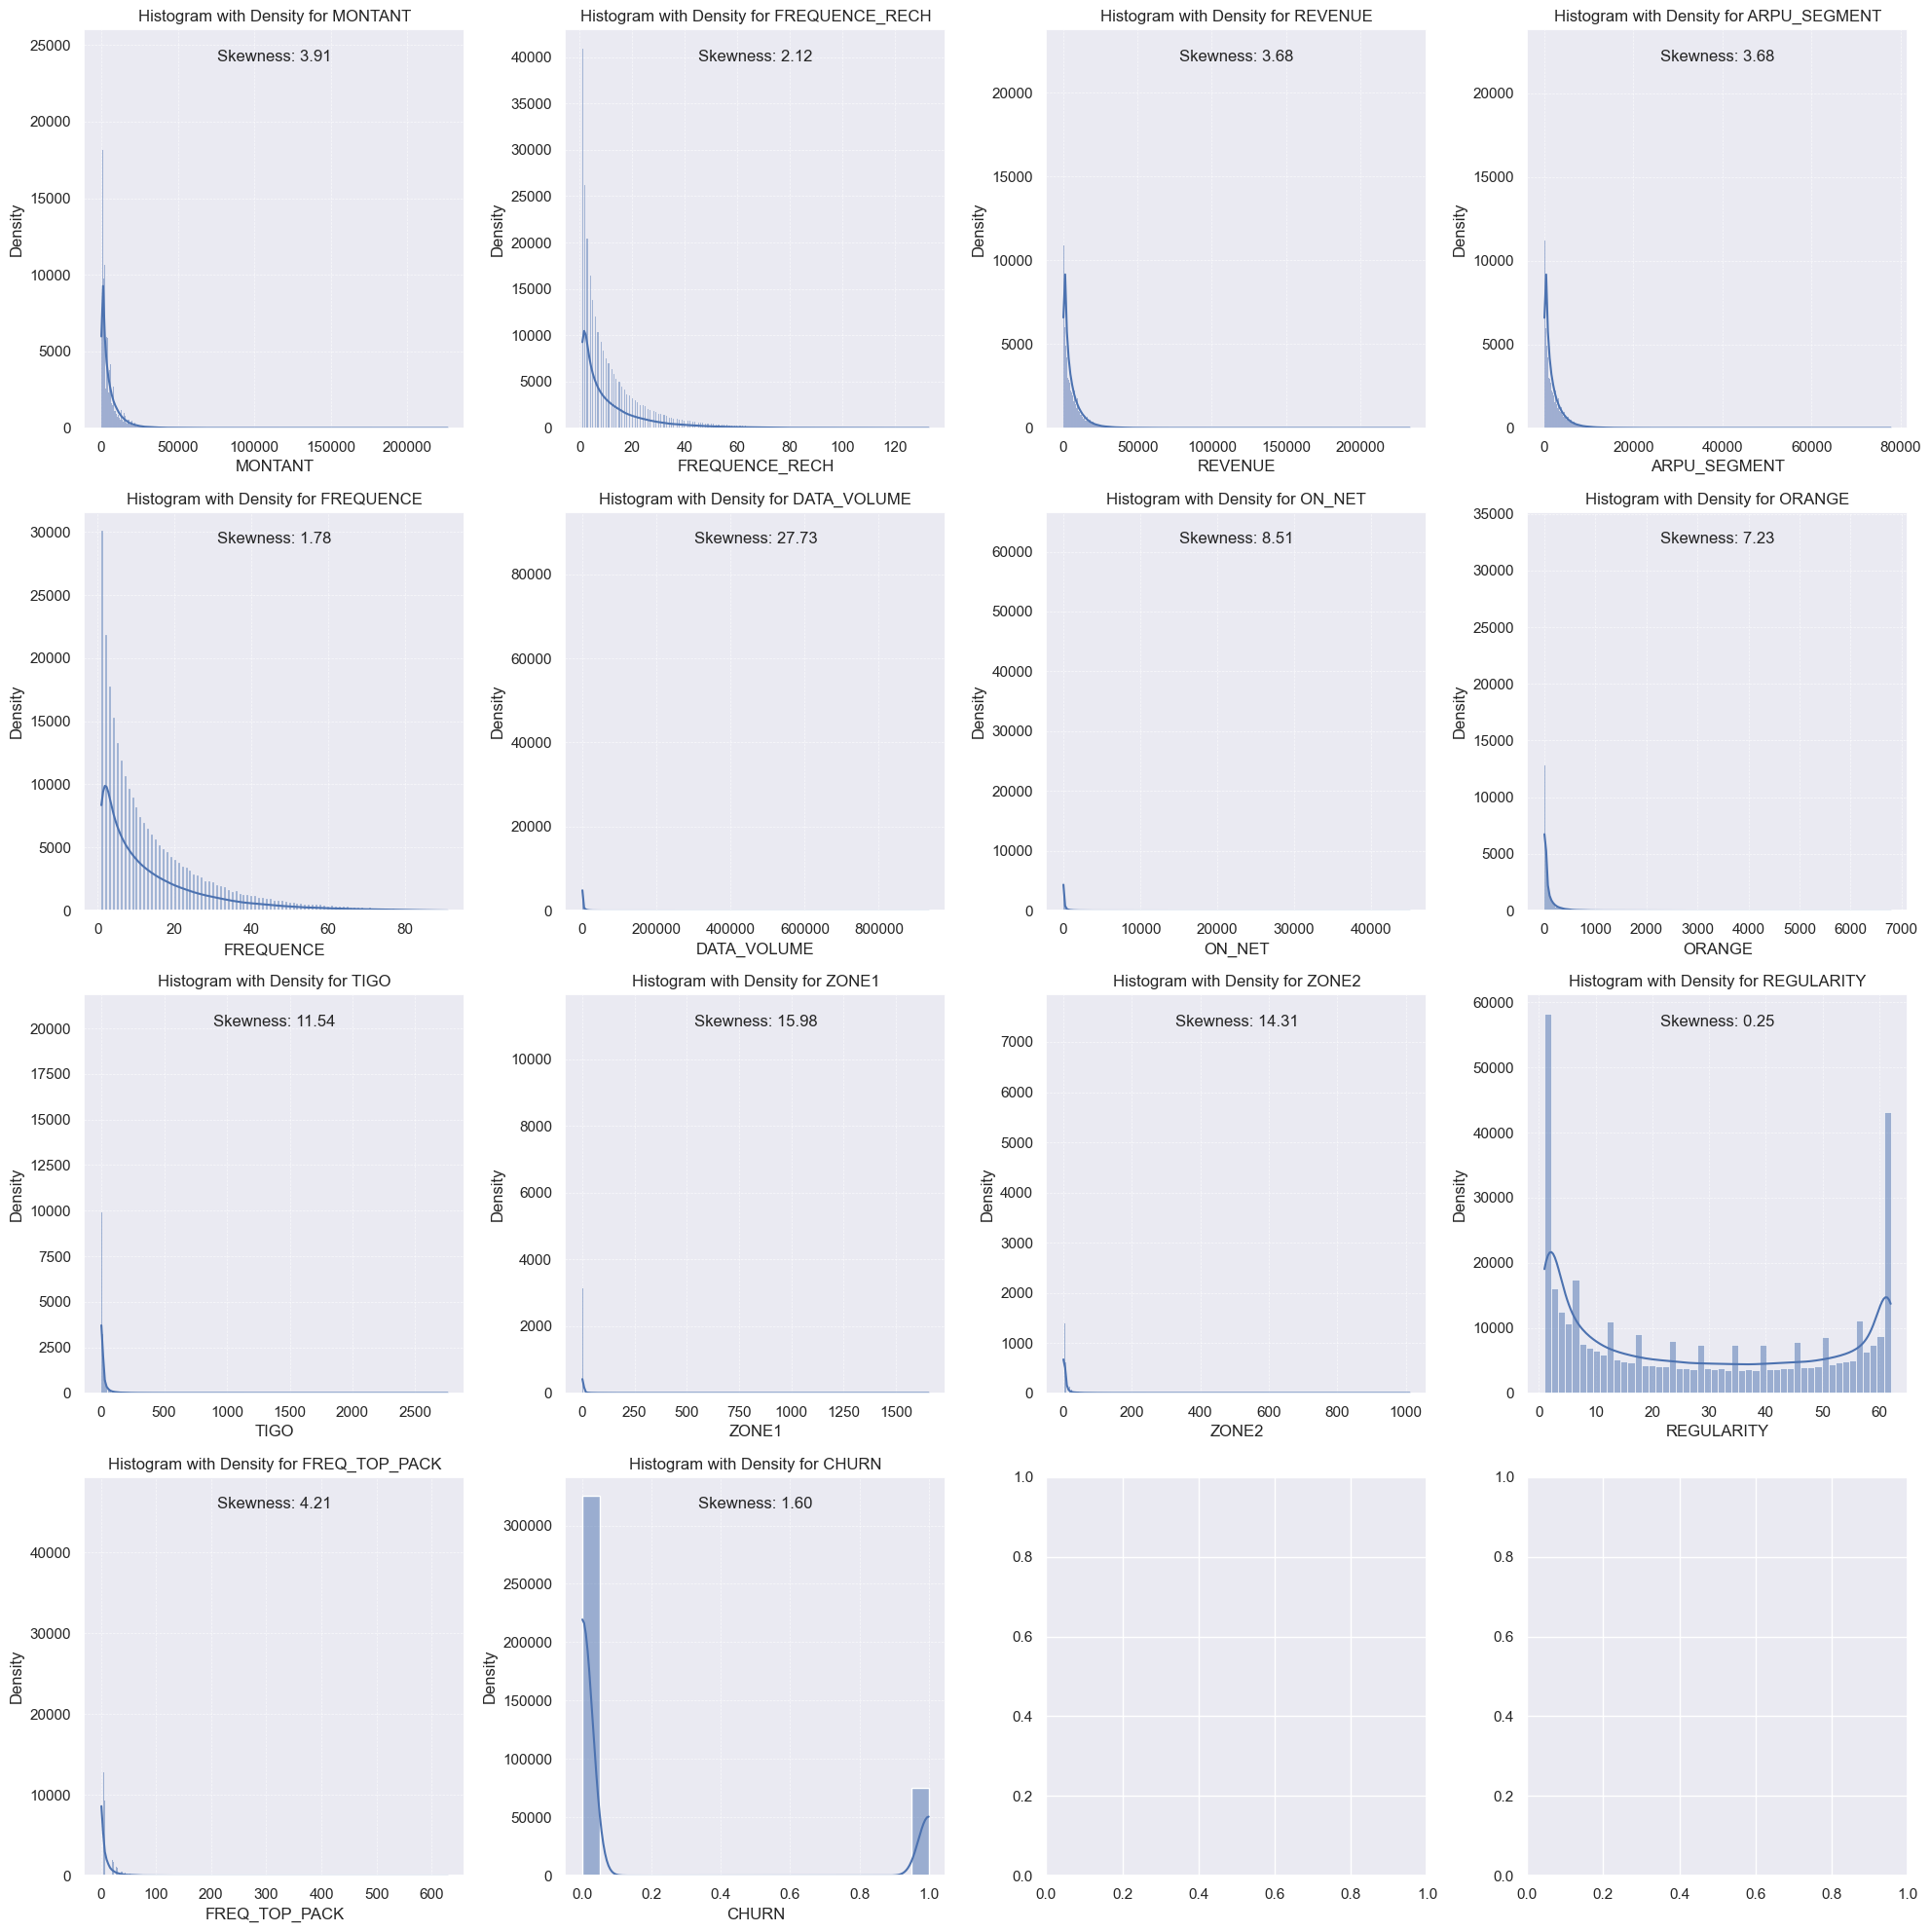

In [49]:
# Set up the matplotlib figure
plt.figure(figsize=(20, 20))

# List of numerical features to plot
numerical_features = train.select_dtypes(include = ['int', 'float']).columns

a = 4
b = 4
c = 1

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Create subplots for each numerical feature
for i, feature in enumerate(numerical_features):
#     fig, axes =  plt.subplot(a, b, c)
    
    # Create the violin plot
    sns.histplot(data= train, x=feature, kde = True, ax = axes[i])
    
    # Add background color and grid
    axes[i].grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    
    # Add titles and labels
    axes[i].set_title(f'Histogram with Density for {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Density')
    skewness = stats.skew(train[feature].dropna())
    axes[i].text(0.5, 0.95, f'Skewness: {skewness:.2f}', horizontalalignment='center', verticalalignment='top', transform=axes[i].transAxes)
    c += 1
# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

<div class="alert alert-block alert-info" >
<b>Inferences</b>
    <p><li>Most of the numeric features in the dataset are heavily right skewed except the 'REGULARITY' feature which seems  to have a multimodal distribution</li></p>
</div>

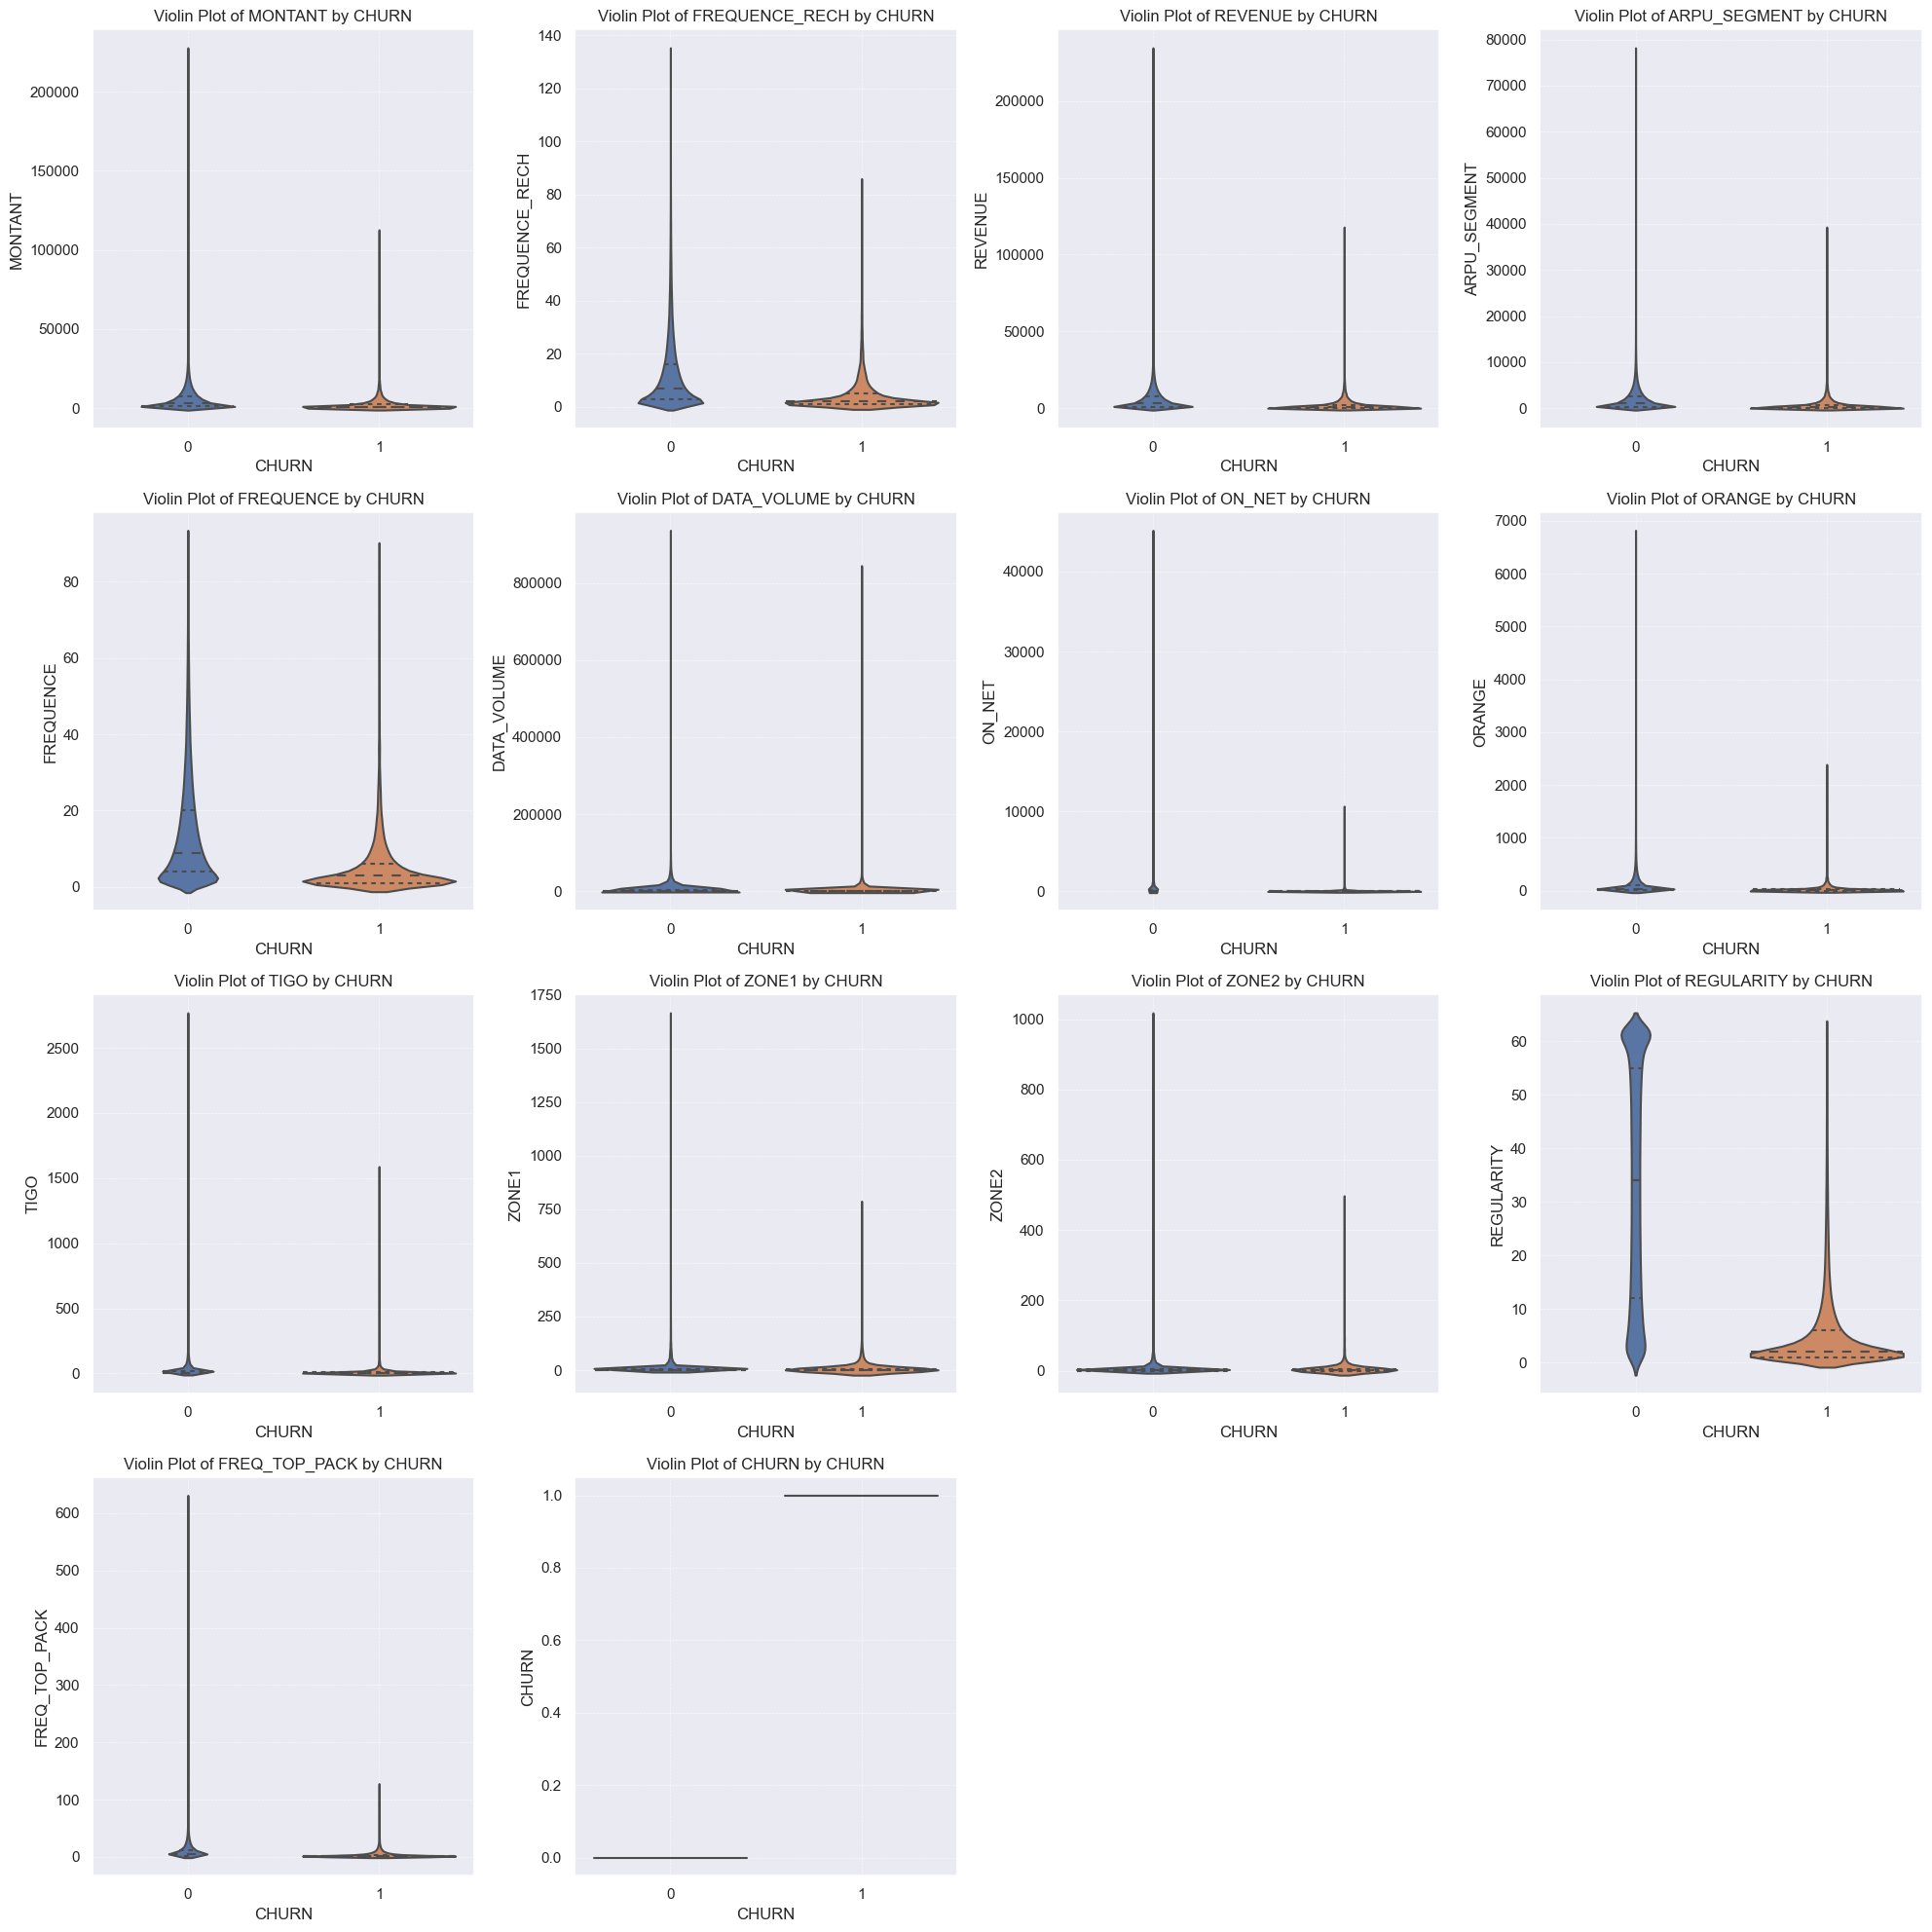

In [50]:
# Set up the matplotlib figure
plt.figure(figsize=(20, 20))
cat_col = ['CHURN']
plots = [(num_val, cat_val) for num_val in numerical_features for cat_val in cat_col]

a = 4
b = 4
c = 1

# Create subplots for each pair
for i, (num_col, cat_col) in enumerate(plots, 1):
    plt.subplot(a, b, c)
    
    # Create the box plot
    sns.violinplot(data=train, x=cat_col, y=num_col, inner = 'quartile')
    
    # Add background color and grid
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    
    # Add titles and labels
    plt.title(f'Violin Plot of {num_col} by {cat_col}')
    plt.xlabel(cat_col)
    plt.ylabel(num_col)
    c = c+1

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

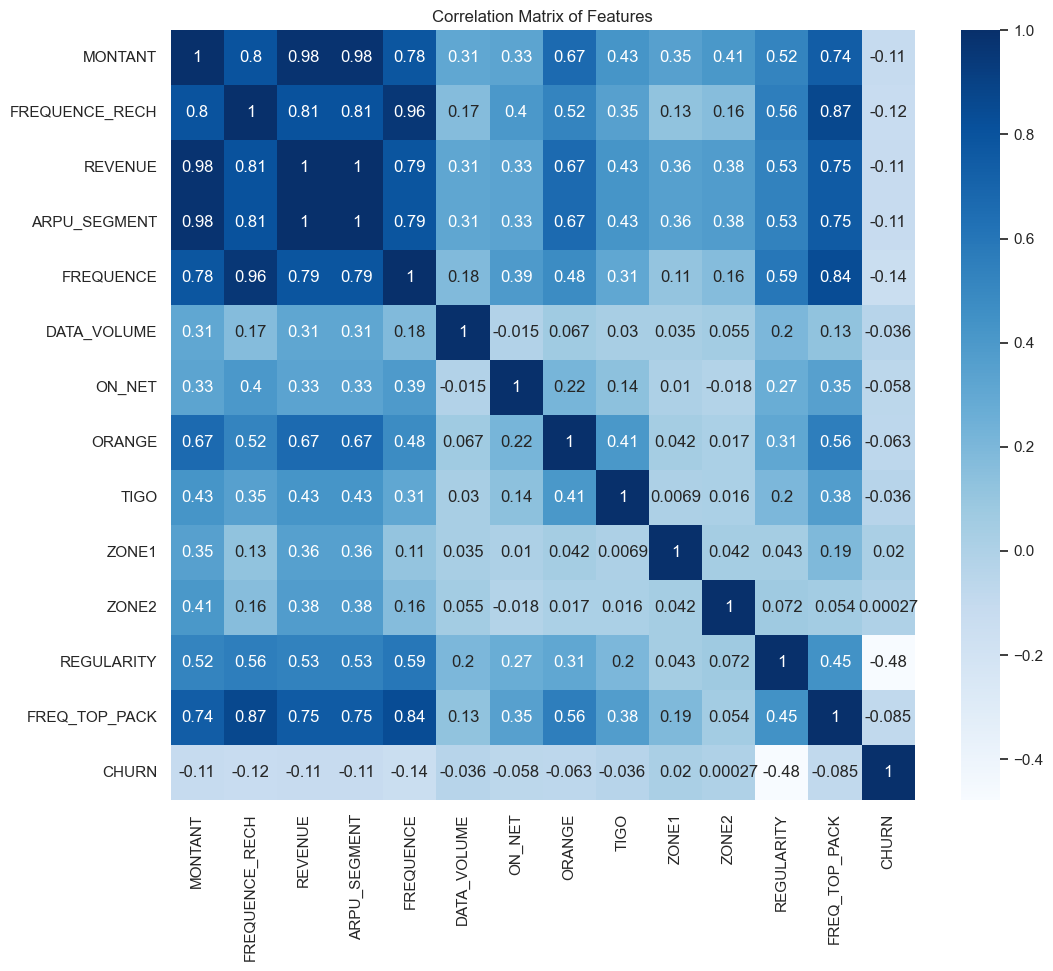

In [12]:
plt.figure(figsize=(12, 10))

# Correlation analysis
matrix = train.corr()
sns.heatmap(matrix, annot=True, cmap='Blues')
plt.title('Correlation Matrix of Features')
plt.show()

<div class="alert alert-block alert-info" >
<b>Inferences</b>
<p><strong>Correlation Coefficients:</strong></p>
<ul>
    <li>The values in the matrix range from -1 to 1.</li>
    <li>A value of <strong>1</strong> indicates a perfect positive correlation, meaning as one variable increases, the other also increases.</li>
    <li>A value of <strong>-1</strong> indicates a perfect negative correlation, meaning as one variable increases, the other decreases.</li>
    <li>A value of <strong>0</strong> suggests no correlation between the variables.</li>
</ul>

<p><strong>Interpretation:</strong></p>
<p><u>High Positive Correlations:</u></p>
<p>
    <strong>MONTANT</strong> and <strong>ARPU_SEGMENT</strong> have a high positive correlation of <strong>0.98</strong>. This suggests that as MONTANT (which might represent the top-up amount spent) increases, the ARPU_SEGMENT (income over 90 days) also increases.
</p>

<p><u>Negative Correlations:</u></p>
<p>
    <strong>CHURN</strong> and <strong>REGULARITY</strong> have a correlation of <strong>-0.48</strong>. This indicates that as regularity increases, the likelihood of churn decreases.
</p>

<p><u>Low or Near-Zero Correlations:</u></p>
<p>
    <strong>TIGO</strong> and <strong>ZONE1</strong> have a very low correlation of <strong>0.0069</strong>, suggesting that these two variables have almost no linear relationship.
</p>


In [13]:
# Create a mask to identify the features with a correlation coefficient greater than or equal to 0.75
high_correlation_mask = matrix >= 0.75

# Identify and list the highly correlated features
highly_correlated_features = []

for feature in high_correlation_mask.columns:
    correlated_with = high_correlation_mask.index[high_correlation_mask[feature]].tolist()
    for correlated_feature in correlated_with:
        if feature != correlated_feature and (correlated_feature, feature) not in highly_correlated_features:
            highly_correlated_features.append((feature, correlated_feature))
# Print the highly correlated features
print('Highly correlated features:')
for feature1, feature2 in highly_correlated_features:
    print(f'{feature1} and {feature2}')

Highly correlated features:
MONTANT and FREQUENCE_RECH
MONTANT and REVENUE
MONTANT and ARPU_SEGMENT
MONTANT and FREQUENCE
FREQUENCE_RECH and REVENUE
FREQUENCE_RECH and ARPU_SEGMENT
FREQUENCE_RECH and FREQUENCE
FREQUENCE_RECH and FREQ_TOP_PACK
REVENUE and ARPU_SEGMENT
REVENUE and FREQUENCE
REVENUE and FREQ_TOP_PACK
ARPU_SEGMENT and FREQUENCE
ARPU_SEGMENT and FREQ_TOP_PACK
FREQUENCE and FREQ_TOP_PACK


In [14]:
# Printing the correlation coefficient of each features and the target variable 'CHURN'
target_corr = matrix['CHURN'].sort_values(ascending=False)
print('Correlations with the target variable:')
print(target_corr)

Correlations with the target variable:
CHURN             1.000000
ZONE1             0.019937
ZONE2             0.000273
TIGO             -0.035890
DATA_VOLUME      -0.036015
ON_NET           -0.057701
ORANGE           -0.063382
FREQ_TOP_PACK    -0.085136
MONTANT          -0.106229
REVENUE          -0.114822
ARPU_SEGMENT     -0.114822
FREQUENCE_RECH   -0.123113
FREQUENCE        -0.139685
REGULARITY       -0.479120
Name: CHURN, dtype: float64


## Feature Extraction

In [15]:
#Checking the count of the 'TOP PACK' feature
pd.set_option('display.max_rows', None)
train['TOP_PACK'].value_counts()

All-net 500F=2000F;5d                                58675
On net 200F=Unlimited _call24H                       28387
Data:490F=1GB,7d                                     21661
Data: 100 F=40MB,24H                                 15590
Mixt 250F=Unlimited_call24H                          12712
MIXT:500F= 2500F on net _2500F off net;2d            12020
Data:1000F=2GB,30d                                   11205
All-net 500F =2000F_AllNet_Unlimited                  8625
Jokko_Daily                                           8436
Data: 200 F=100MB,24H                                 8086
IVR Echat_Daily_50F                                   5264
On-net 500=4000,10d                                   4955
On-net 500F_FNF;3d                                    4135
Data:200F=Unlimited,24H                               4049
MIXT: 200mnoff net _unl on net _5Go;30d               3553
On-net 1000F=10MilF;10d                               3409
VAS(IVR_Radio_Daily)                                  27

In [16]:
#Checking the values and count of the 'TENURE' feature
pd.reset_option('display.max_rows')
train['TENURE'].value_counts()

K > 24 month     379439
I 18-21 month      8312
H 15-18 month      4858
G 12-15 month      2788
J 21-24 month      2325
F 9-12 month       1771
E 6-9 month         359
D 3-6 month         148
Name: TENURE, dtype: int64

In [17]:
# Dictionary mapping customer tenure codes to descriptive terms
tenure_dict = {
    'K > 24 month': 'Longer_term',          # Customers with tenure greater than 24 months are labeled as Longer_term
    'J 21-24 month': 'Long_trem',          # Customers with tenure between 21 and 24 months are labeled as Long_term 
    'I 18-21 month': 'Medium_term',       # Customers with tenure between 18 and 21 months are labeled as Medium_term
    'H 15-18 month': 'Medium_term',       # Customers with tenure between 15 and 18 months are also labeled as Medium_term
    'G 12-15 month': 'Mid_term',          # Customers with tenure between 12 and 15 months are labeled as Mid_term
    'F 9-12 month': 'Mid_term',           # Customers with tenure between 9 and 12 months are also labeled as Mid_term
    'E 6-9 month': 'Short_term',          # Customers with tenure between 6 and 9 months are labeled as Short_term
    'D 3-6 month': 'Shorter_term'      # Customers with tenure between 3 and 6 months are labeled as Shorter_term
}


In [18]:
# List of keywords related to voice call packages in the 'TOP_PACK' feature
call = [
    'all-net', 'on net', 'on-net', 'crbt', 'cvm', 'postpaid', 'unlimited', 
    'grps', 'incoming', 'mixt', 'gprs', 'ymgx', 'fnf', 'chinguitel'
]

# List of keywords related to data packages in the 'TOP_PACK' feature
services = [
    'vas', 'ivr', 'pilot', 'APANews', 'jokko_promo', 'jokko', 'fifa_ts_daily',
    'yakalma', 'mromo', 'supermagik', 'evc'
]

# List of other miscellaneous keywords that do not fit into the 'call' or 'services' categories
others = [
    'yewouleen', 'yakalma', 'liberte', '301765007', '305155009', 
    'staff_cpe_rent', '10mnonnet'
]

# Creating a copy of the training dataset to ensure the original data remains unchanged during processing
train_df = train.copy()


In [19]:
def Feature_Extraction(df):
    # Categorize 'TOP_PACK' based on keywords related to calls
    df['TOP_PACK'] = np.where(
        df['TOP_PACK'].str.contains('|'.join(call), case=False, na=False, regex=True), 
        'call', 
        df['TOP_PACK']
    )
    
    # Categorize 'TOP_PACK' based on keywords related to services
    df['TOP_PACK'] = np.where(
        df['TOP_PACK'].str.contains('|'.join(services), case=False, na=False, regex=True), 
        'VAS', 
        df['TOP_PACK']
    )

    # Categorize 'TOP_PACK' as 'data' if it contains 'data' or 'wifi'
    df['TOP_PACK'] = np.where(
        df['TOP_PACK'].str.contains('data|wifi', case=False, na=False), 
        'data', 
        df['TOP_PACK']
    )

    # Categorize 'TOP_PACK' as 'international' if it contains 'internat'
    df['TOP_PACK'] = np.where(
        df['TOP_PACK'].str.contains('internat', case=False, na=False), 
        'international', 
        df['TOP_PACK']
    )

    # Categorize 'TOP_PACK' as 'social media' if it contains 'twter' or 'facebook'
    df['TOP_PACK'] = np.where(
        df['TOP_PACK'].str.contains('twter|facebook', case=False, na=False), 
        'social media', 
        df['TOP_PACK']
    )
    
    # Categorize 'TOP_PACK' based on other miscellaneous keywords
    df['TOP_PACK'] = np.where(
        df['TOP_PACK'].str.contains('|'.join(others), case=False, na=False, regex=True), 
        'others', 
        df['TOP_PACK']
    )
    
    # Create a new column 'min_tenure' with numeric values representing the minimum tenure in months
    df['min_tenure'] = df['TENURE'].map({
        'K > 24 month': 24, 'J 21-24 month': 21, 'I 18-21 month': 18,
        'H 15-18 month': 15, 'G 12-15 month': 12, 'F 9-12 month': 9, 
        'E 6-9 month': 6, 'D 3-6 month': 3
    })
    
    # Map 'TENURE' values to more descriptive terms using the tenure_dict dictionary
    df['TENURE'] = df['TENURE'].map(tenure_dict)
    
    return df


In [20]:
# Extracing features from the top 'TOP_PACK' and 'TENURE' columns
Feature_Extraction(train_df)

,user_id,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,MRG,REGULARITY,TOP_PACK,FREQ_TOP_PACK,CHURN,min_tenure
0,dcf68cc2fb515ccad7d8b9b3bd80ee2a4b270063,SAINT-LOUIS,Longer_term,17000.0,32.0,18000.0,6000.0,34.0,NaN,97.0,355.0,6.0,NaN,NaN,NO,62,call,35.0,0,24
1,71c44b5ba328db5c4192a80f7cf8f244d9350ed0,NaN,Longer_term,4300.0,29.0,4427.0,1476.0,37.0,1764.0,8.0,3.0,0.0,NaN,2.0,NO,40,data,22.0,0,24
2,ce46411b1526c94f20a383b8cb188f8d27f82a0a,TAMBACOUNDA,Longer_term,1500.0,3.0,1500.0,500.0,3.0,NaN,30.0,30.0,NaN,NaN,NaN,NO,32,call,3.0,0,24
3,f467cdb6669818373c26c2bad44e01ba66f97d21,FATICK,Longer_term,1500.0,3.0,2497.0,832.0,4.0,0.0,159.0,45.0,19.0,NaN,NaN,NO,18,call,3.0,0,24
4,ec45e1a1888a32b5dcce0954cfec20c6e037db31,FATICK,Longer_term,NaN,NaN,498.0,166.0,3.0,1.0,1.0,3.0,NaN,NaN,NaN,NO,50,NaN,NaN,0,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399995,a892ad4ed0eda8dc721733200c47147763b183ec,TAMBACOUNDA,Longer_term,700.0,2.0,704.0,235.0,3.0,NaN,12.0,14.0,NaN,NaN,NaN,NO,46,call,1.0,0,24
399996,13daa3a651bf0192a413b339c4766aeafc6d1636,NaN,Longer_term,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,14,NaN,NaN,0,24
399997,767f596aee426962f7d92f4de8d7b232cdc17568,NaN,Longer_term,700.0,2.0,699.0,233.0,5.0,237.0,1.0,NaN,NaN,NaN,NaN,NO,15,data,3.0,0,24
399998,b831e4d3b59a1e294e9e0a2aab391bc12d50845c,NaN,Longer_term,NaN,NaN,9.0,3.0,1.0,0.0,NaN,0.0,NaN,NaN,NaN,NO,5,NaN,NaN,1,24


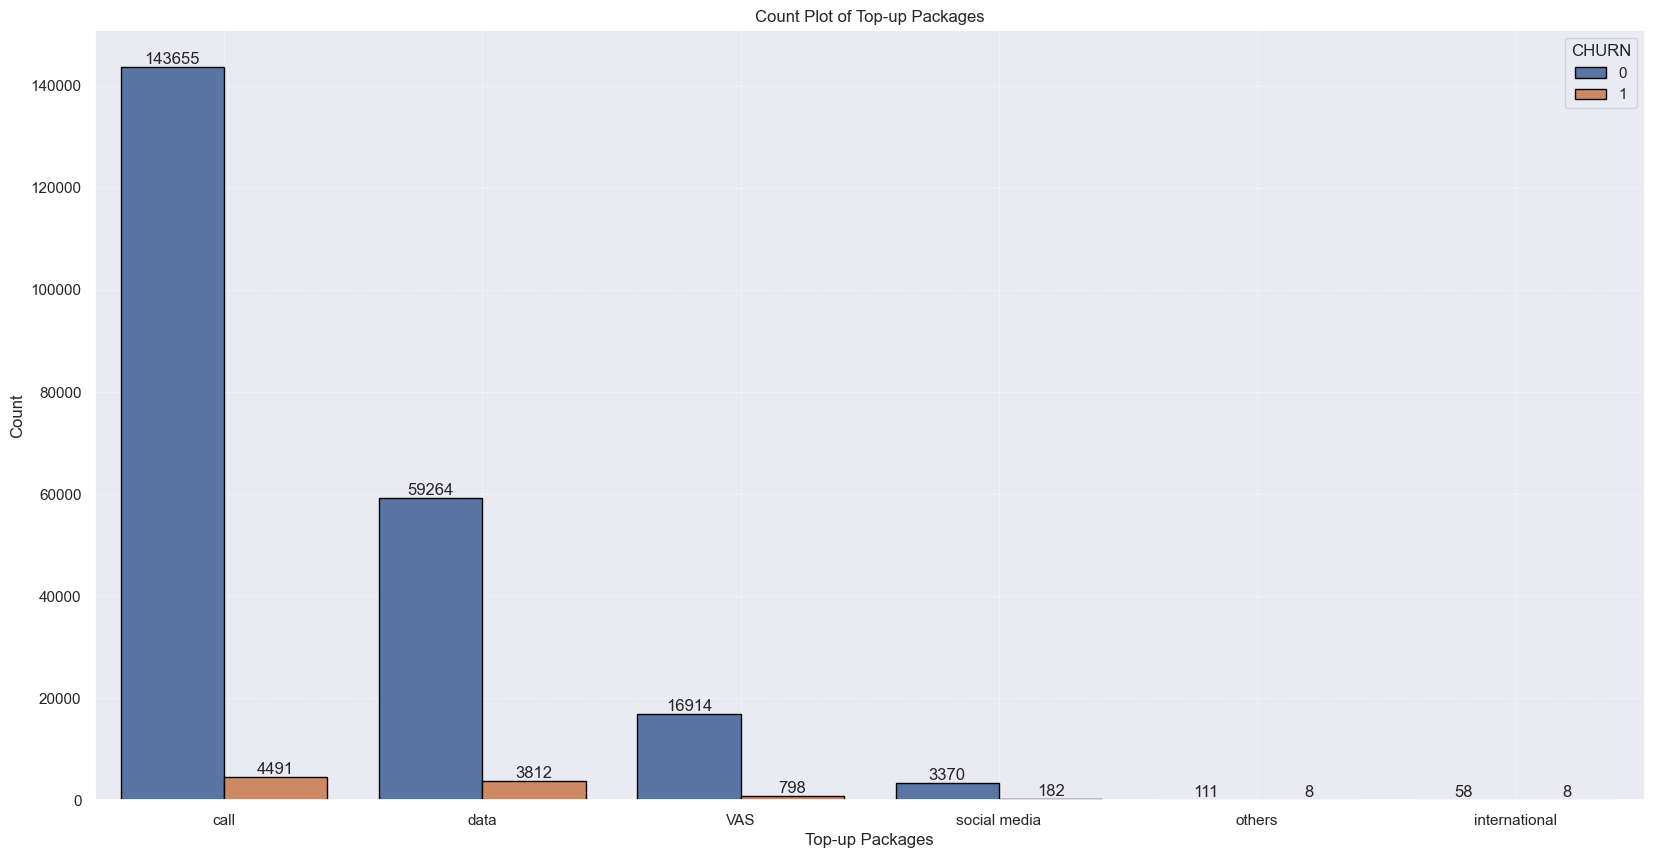

In [21]:
# Set up the figure size for the plot
plt.figure(figsize=(20, 10))

# Create a countplot of customers by their top-up packages, with churn status as a hue
ax = sns.countplot(data=train_df, x='TOP_PACK', hue='CHURN', edgecolor='black')

# Add a grid to the plot for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Add labels to each bar in the countplot to show the exact counts
for container in ax.containers:
    ax.bar_label(container)

# Add a title to the plot
plt.title('Count Plot of Top-up Packages')

# Label the x-axis as 'Top-up Packages'
plt.xlabel('Top-up Packages')

# Label the y-axis as 'Count'
plt.ylabel('Count')

# Display the plot
plt.show()


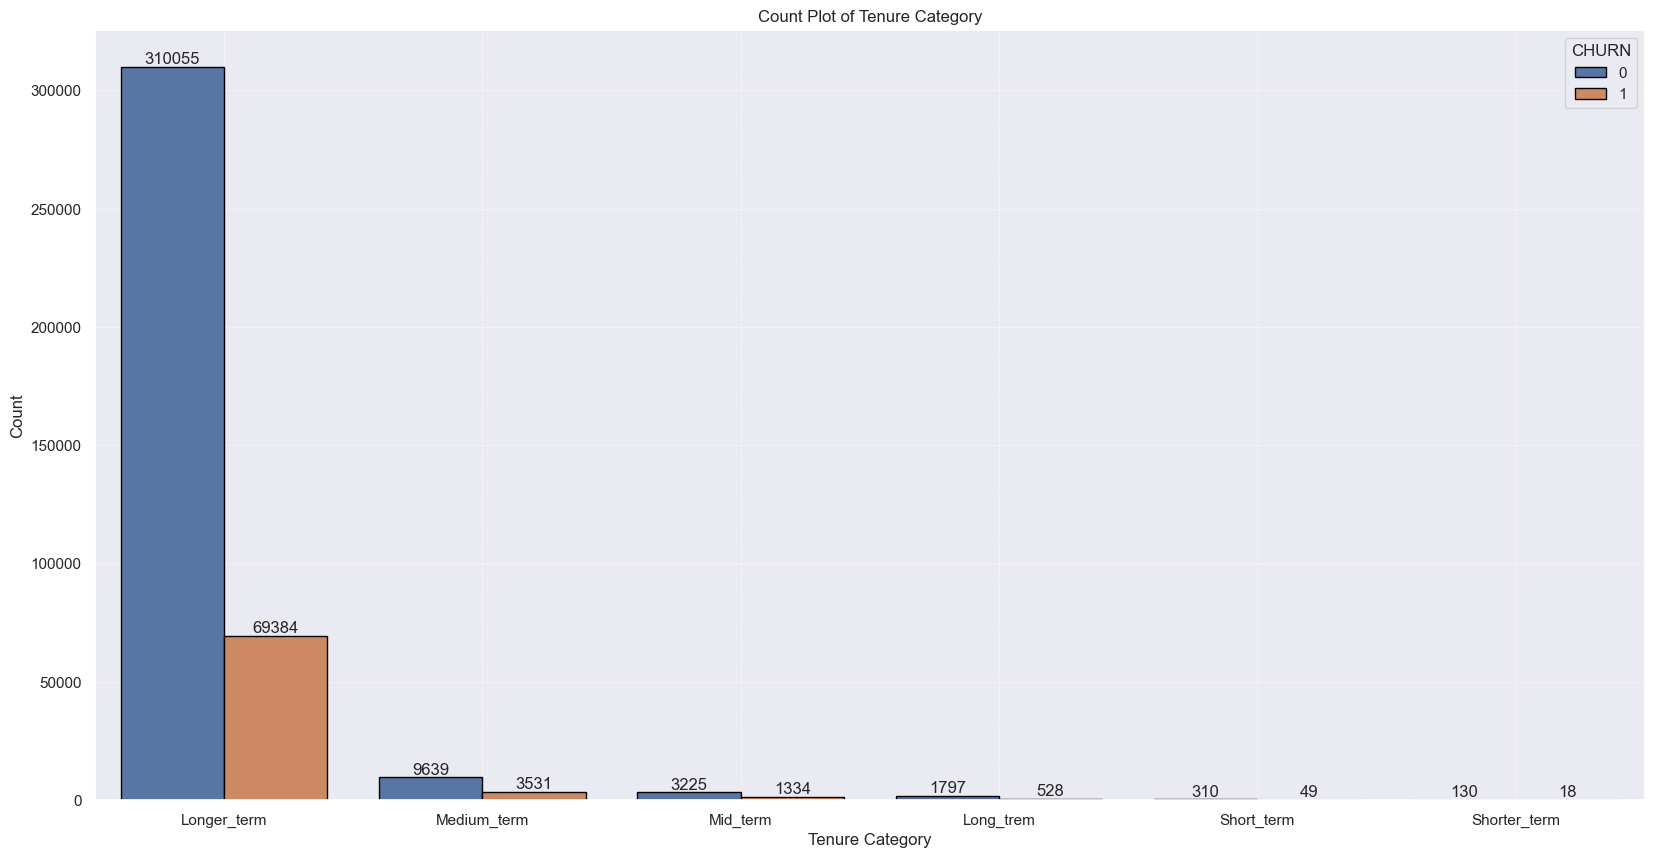

In [22]:
# Set up the figure size for the plot
plt.figure(figsize=(20, 10))

# Create a countplot of customers by their tenure category, with churn status as a hue
ax = sns.countplot(data=train_df, x='TENURE', hue='CHURN', edgecolor='black')

# Add a grid to the plot for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Add labels to each bar in the countplot to show the exact counts
for container in ax.containers:
    ax.bar_label(container)

# Add a title to the plot
plt.title('Count Plot of Tenure Category')

# Label the x-axis as 'Tenure Category'
plt.xlabel('Tenure Category')

# Label the y-axis as 'Count'
plt.ylabel('Count')

# Display the plot
plt.show()


## Missing Value Analysis

In [23]:
#Viewing the percentage of missing values.
train_df.isnull().mean()* 100

user_id            0.00000
REGION            39.38000
TENURE             0.00000
MONTANT           35.06925
FREQUENCE_RECH    35.06925
REVENUE           33.66575
ARPU_SEGMENT      33.66575
FREQUENCE         33.66575
DATA_VOLUME       49.21350
ON_NET            36.45475
ORANGE            41.57925
TIGO              59.84650
ZONE1             92.07750
ZONE2             93.62175
MRG                0.00000
REGULARITY         0.00000
TOP_PACK          41.83225
FREQ_TOP_PACK     41.83225
CHURN              0.00000
min_tenure         0.00000
dtype: float64

<Axes: >

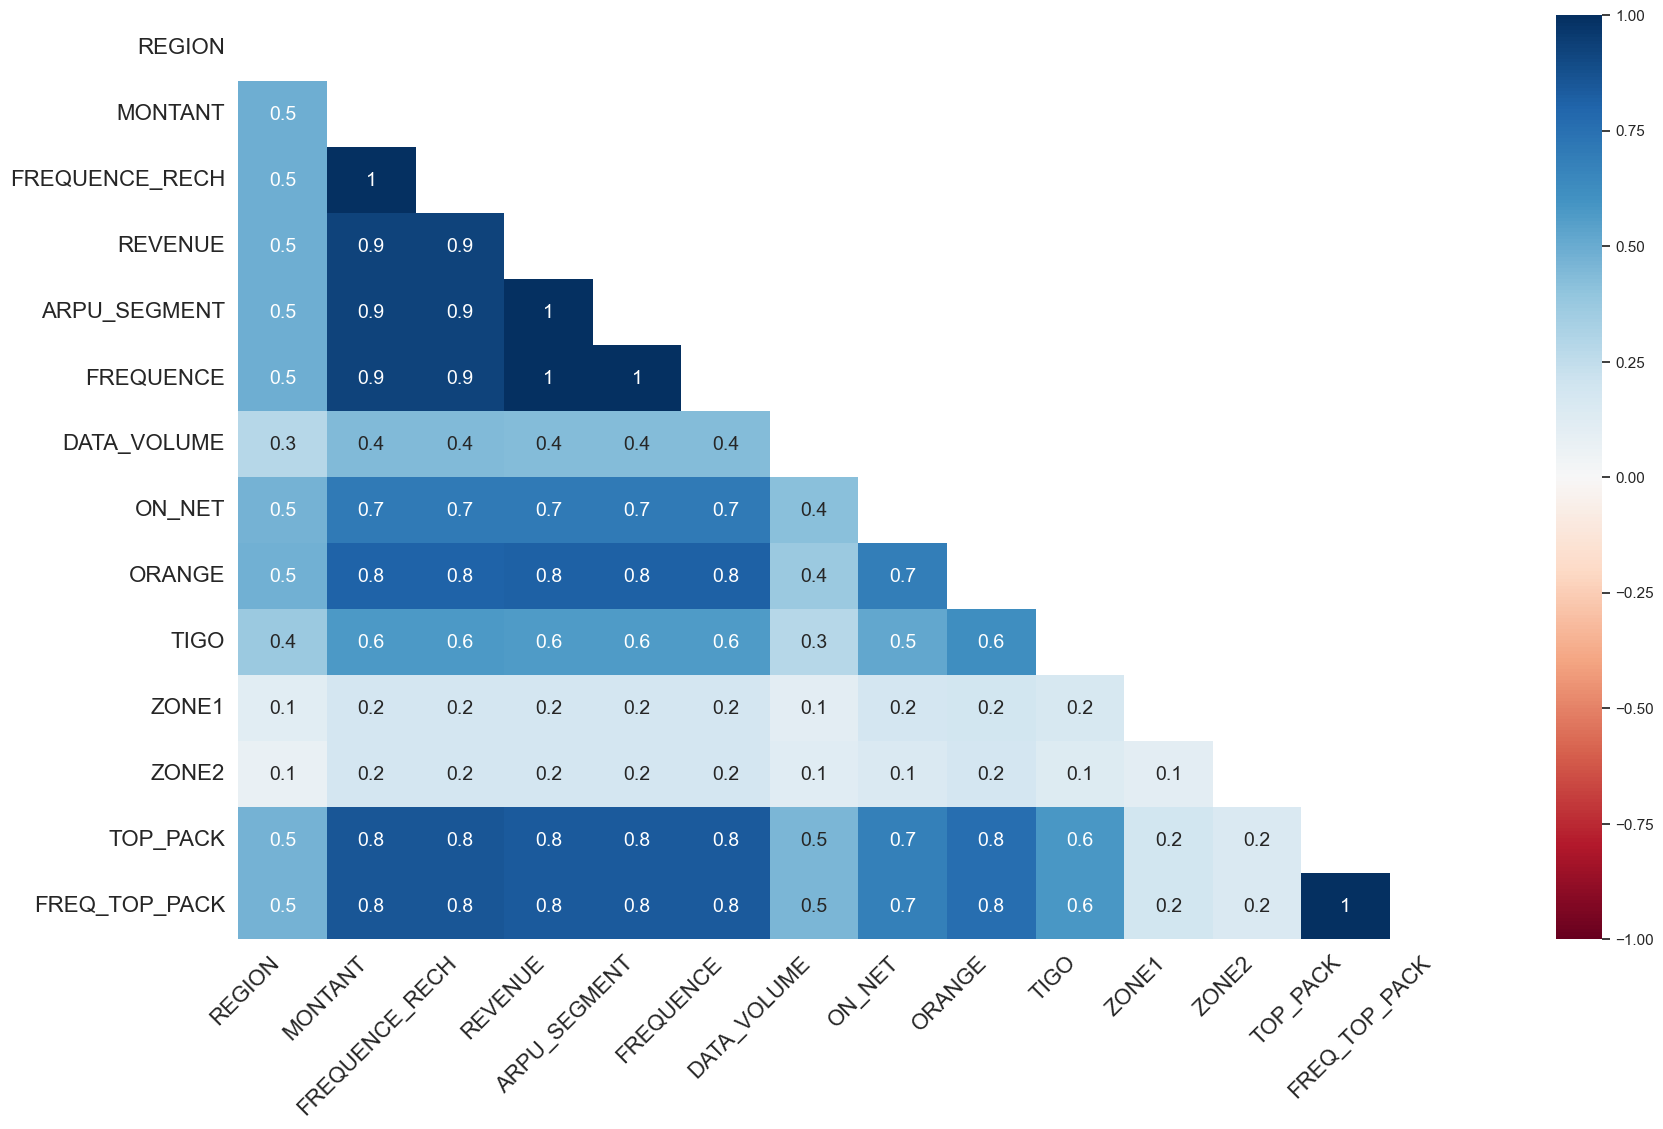

In [24]:
# Generate a heatmap to visualize the correlation of missing data in the DataFrame
msno.heatmap(train_df)

<div class="alert alert-block alert-info" >
<h2>Interpreting the Heatmap</h2>
<ul>
    <li><strong>High Correlations:</strong> If you observe high correlations (dark blue) between missing values in certain columns, it suggests that the missingness in one column is related to missingness in another column. This might indicate MAR, where missingness in one variable is dependent on another observed variable.</li>
    <li><strong>Low or No Correlations:</strong> If most correlations are low or near zero, it suggests that the missingness is likely MCAR, as there’s no apparent relationship between the missing values across different columns.</li>
    <li><strong>Complex Patterns:</strong> If the heatmap shows complex patterns, it might suggest MNAR, but further investigation would be required to confirm this. MNAR is harder to diagnose through a simple heatmap.</li>
</ul>
    
   <p> The 'ZONE1' and 'ZONE2' columns are MCAR as they have little to no correlations to the missing values in the other columns. They can be dropped as they have the highest percentage of missing values while a column which is a missing value indicator will be created for the other variables as they show moderate correlation with the missing values in other columns.
</div>

In [25]:
# Dropping the 'ZONE1' and 'ZONE2' columns
train_df.drop(['ZONE1', 'ZONE2'], axis = 1, inplace = True)

In [26]:
# Creating a list containing highly skewed features
skewed_features = ['MONTANT', 'FREQUENCE_RECH', 'REVENUE', 'ARPU_SEGMENT',
                    'FREQUENCE', 'DATA_VOLUME', 'ON_NET', 'ORANGE', 'TIGO', 'FREQ_TOP_PACK']
# Creating a list containing the features we will like to create a missing value indicator for
null_cols = ['REGION', 'MONTANT', 'FREQUENCE_RECH', 'REVENUE', 'ARPU_SEGMENT', 'FREQUENCE', 'DATA_VOLUME', 'ON_NET', 'ORANGE', 'TIGO', 'TOP_PACK', 'FREQ_TOP_PACK']

In [27]:
def Feature_Engineering(df):
    # Apply log transformation to skewed features to reduce skewness
    # Adding a small constant (1e-9) to avoid taking the log of zero
    for column in skewed_features:
        df[column + '_log'] = np.log(df[column] + 1e-9)
    
    # Create binary features indicating missing values in specified columns
    # This helps in capturing missing value patterns explicitly
    for cols in null_cols:
        df[cols + '_missing'] = np.where(df[cols].isnull(), 1, 0)
    
    return df


In [28]:
#Engineering features
Feature_Engineering(train_df)

,user_id,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,...,FREQUENCE_RECH_missing,REVENUE_missing,ARPU_SEGMENT_missing,FREQUENCE_missing,DATA_VOLUME_missing,ON_NET_missing,ORANGE_missing,TIGO_missing,TOP_PACK_missing,FREQ_TOP_PACK_missing
0,dcf68cc2fb515ccad7d8b9b3bd80ee2a4b270063,SAINT-LOUIS,Longer_term,17000.0,32.0,18000.0,6000.0,34.0,NaN,97.0,...,0,0,0,0,1,0,0,0,0,0
1,71c44b5ba328db5c4192a80f7cf8f244d9350ed0,NaN,Longer_term,4300.0,29.0,4427.0,1476.0,37.0,1764.0,8.0,...,0,0,0,0,0,0,0,0,0,0
2,ce46411b1526c94f20a383b8cb188f8d27f82a0a,TAMBACOUNDA,Longer_term,1500.0,3.0,1500.0,500.0,3.0,NaN,30.0,...,0,0,0,0,1,0,0,1,0,0
3,f467cdb6669818373c26c2bad44e01ba66f97d21,FATICK,Longer_term,1500.0,3.0,2497.0,832.0,4.0,0.0,159.0,...,0,0,0,0,0,0,0,0,0,0
4,ec45e1a1888a32b5dcce0954cfec20c6e037db31,FATICK,Longer_term,NaN,NaN,498.0,166.0,3.0,1.0,1.0,...,1,0,0,0,0,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399995,a892ad4ed0eda8dc721733200c47147763b183ec,TAMBACOUNDA,Longer_term,700.0,2.0,704.0,235.0,3.0,NaN,12.0,...,0,0,0,0,1,0,0,1,0,0
399996,13daa3a651bf0192a413b339c4766aeafc6d1636,NaN,Longer_term,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,1,1,1,1,1,1,1,1,1
399997,767f596aee426962f7d92f4de8d7b232cdc17568,NaN,Longer_term,700.0,2.0,699.0,233.0,5.0,237.0,1.0,...,0,0,0,0,0,0,1,1,0,0
399998,b831e4d3b59a1e294e9e0a2aab391bc12d50845c,NaN,Longer_term,NaN,NaN,9.0,3.0,1.0,0.0,NaN,...,1,0,0,0,0,1,0,1,1,1


In [29]:
# Drop columns 'user_id', 'CHURN', and 'MRG' from the DataFrame
# 'user_id' is an identifier and not useful for model training
# 'CHURN' is the target variable we want to predict, so it should not be in the feature set
# 'MRG' is excluded as it might not be relevant for the model seeing that it has only one value
# Resulting DataFrame 'x' will contain only the features used for model training
x = train_df.drop(['user_id', 'CHURN', 'MRG'], axis=1)

# Extract the 'CHURN' column from the DataFrame
# This column contains the target variable which indicates whether a user has churned
# 'y' will be used as the target variable for training the model
y = train_df['CHURN']


In [30]:
# Computing class weights
# Convert y to a NumPy array if it's not already one
arr = np.array(y)

# Calculate unique classes in y
unique_classes = np.unique(arr)

# Convert unique_classes to a list to ensure hashability
unique_classes_list = list(unique_classes)

# Calculate class weights based on the training data
class_weights = compute_class_weight('balanced', classes=unique_classes_list, y= y)

# Create a dictionary of class weights
class_weights_dict = dict(zip(unique_classes_list, class_weights))
print(class_weights_dict)

{0: 0.6150893724858222, 1: 2.6722248944471167}


## Data Modelling

<b>Split the Data</b>
<ul>
    <li><strong>Training and Testing Split:</strong> Divide the data into training and testing sets to evaluate model performance. Typically, a portion of the data is reserved for testing.</li>
    <li><strong>Validation Split:</strong> Further split the training data into training and validation sets to tune hyperparameters and prevent overfitting.</li>
</ul>

<b>Choose and Build a Model</b>
<ul>
    <li><strong>Model Selection:</strong> Choose appropriate algorithms based on the problem type (e.g., linear regression, decision trees, neural networks).</li>
    <li><strong>Model Building:</strong> Implement and configure the chosen model using libraries and frameworks (e.g., scikit-learn).</li>
</ul>

<b>Train the Model</b>
<ul>
    <li><strong>Model Training:</strong> Fit the model to the training data, learning patterns and relationships from the features to predict the target variable.</li>
</ul>

<b>Evaluate the Model</b>
<ul>
    <li><strong>Performance Metrics:</strong> Assess model performance using metrics relevant to the problem (e.g., accuracy, precision, recall, F1-score,log loss, ROC-AUC for classification).</li>
    <li><strong>Cross-Validation:</strong> Use techniques like k-fold cross-validation to evaluate the model’s performance across different subsets of the data.</li>
</ul>

<b>Hyperparameter Tuning</b>
<ul>
    <li><strong>Optimize Parameters:</strong> Use techniques such as Random Search to find the optimal hyperparameters for the model.</li>
    <li><strong>Validation Set:</strong> Use the validation set to tune and select the best hyperparameters.</li>
    <li><strong>Retraining:</strong> Retraining the model on a combination of the training and validation set.</li>
</ul>

<b>Test the Model</b>
<ul>
    <li><strong>Final Evaluation:</strong> Assess the model’s performance on the test set to ensure it generalizes well to unseen data.</li>
    <li><strong>Performance Analysis:</strong> Compare test results with performance metrics and ensure the model meets the desired objectives.</li>
</ul>



In [31]:
# Splitting the dataset into train, validation and test dataset 60%-20%-20%
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=105, stratify = y)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=105, stratify = y_train)

In [39]:
numeric = ['MONTANT', 'FREQUENCE_RECH', 'REVENUE', 'ARPU_SEGMENT', 'FREQUENCE', 'DATA_VOLUME', 'ON_NET', 'ORANGE', 'TIGO', 'REGULARITY']

In [40]:
# Identify categorical features (non-numeric) and numeric features (int and float) in the dataset
categorical_features = x.select_dtypes(exclude=['int', 'float']).columns
# numeric_features = x.select_dtypes(include=['int', 'float']).columns

# Define a pipeline for preprocessing numeric features
# 1. Impute missing values using the median value of each column
# 2. Scale features to a range between 0 and 1 using MinMaxScaler
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),  # Fill missing values with the median
        ("scaler", MinMaxScaler())  # Normalize features to a [0, 1] range
    ]
)

# Define a pipeline for preprocessing categorical features
# 1. Impute missing values using the most frequent value in each column
# 2. Encode categorical features using one-hot encoding to convert them into a numerical format
categorical_transformer = Pipeline(
    steps=[
        ("cat_imputer", SimpleImputer(strategy="most_frequent")),  # Fill missing values with the most frequent value
        ("encoder", OneHotEncoder(handle_unknown="ignore"))  # Convert categorical features to one-hot encoded format
    ]
)

# Combine the numeric and categorical transformers into a single ColumnTransformer
# This allows for parallel processing of different feature types
# - 'num': Applies numeric_transformer to numeric_features
# - 'cat': Applies categorical_transformer to categorical_features
# 'remainder='passthrough'' ensures that any columns not specified are passed through unchanged
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric),  # Apply numeric pipeline to numeric features
        ("cat", categorical_transformer, categorical_features)  # Apply categorical pipeline to categorical features
    ],
    remainder='passthrough'  # Leave any columns not specified unchanged
)


In [34]:
def evaluate_model(model, X_test, y_test):
    """
    Evaluates a machine learning classification model using various metrics, including log loss.
    
    Parameters:
    - model: The trained machine learning model.
    - X_test: The test features.
    - y_test: The true labels for the test set.
    
    Returns:
    - A dictionary with evaluation metrics, including TP, FN, FP, and TN.
    """
    
    # Predict the labels on the test set
    y_pred = model.predict(X_test)
    
    # Predict probabilities for log loss calculation
    y_pred_proba = model.predict_proba(X_test)
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    logloss = log_loss(y_test, y_pred_proba)
    
    # Print classification report
    print("Classification Report:\n", classification_report(y_test, y_pred))
    
    # Compute confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(
        value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(
        group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
    plt.ylabel('Actual Class')
    plt.xlabel('Predicted Class')
    plt.show()
    
    # Return the evaluation metrics as a dataframe
    # Define a dictionary with metric names as keys and metric values as values
    metrics = {
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Log Loss'],
        'Score': [accuracy, precision, recall, f1, logloss]
    }

    # Convert the dictionary to a DataFrame and transpose it for better readability
    metrics_df = pd.DataFrame(metrics)

    return metrics_df
    


In [35]:
# A function for preprocessing the test set
def preprocess_testset(df):
    df = Feature_Extraction(df)
    df.drop(['ZONE1', 'ZONE2', 'user_id', 'MRG'], axis = 1, inplace = True)
    df = Feature_Engineering(df)
    return df

In [36]:
#Preprocessing the test set for prediction
preprocess_testset(test)

,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,...,FREQUENCE_RECH_missing,REVENUE_missing,ARPU_SEGMENT_missing,FREQUENCE_missing,DATA_VOLUME_missing,ON_NET_missing,ORANGE_missing,TIGO_missing,TOP_PACK_missing,FREQ_TOP_PACK_missing
0,NaN,Longer_term,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,1,1,1,1,1,1,1,1,1
1,NaN,Longer_term,NaN,NaN,10.0,3.0,1.0,NaN,NaN,NaN,...,1,0,0,0,1,1,1,1,1,1
2,NaN,Longer_term,1900.0,15.0,2299.0,766.0,21.0,414.0,NaN,7.0,...,0,0,0,0,0,1,0,0,0,0
3,DAKAR,Longer_term,3000.0,9.0,2603.0,868.0,14.0,332.0,0.0,23.0,...,0,0,0,0,0,0,0,0,0,0
4,DAKAR,Longer_term,32000.0,47.0,33000.0,11000.0,47.0,NaN,128.0,555.0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,LOUGA,Longer_term,200.0,1.0,20.0,7.0,1.0,NaN,NaN,0.0,...,0,0,0,0,1,1,0,1,1,1
99996,TAMBACOUNDA,Longer_term,1000.0,1.0,998.0,333.0,4.0,1.0,6.0,3.0,...,0,0,0,0,0,0,0,1,1,1
99997,NaN,Medium_term,1800.0,7.0,1799.0,600.0,9.0,81.0,2.0,0.0,...,0,0,0,0,0,0,0,1,0,0
99998,THIES,Longer_term,2500.0,4.0,2515.0,838.0,4.0,NaN,43.0,106.0,...,0,0,0,0,1,0,0,0,0,0


In [37]:
sample_sub = pd.read_csv('sample_submission.csv')
sample_sub.head()

,user_id,CHURN
0,af900d87e73b7ff6509d2203df4704a98aa5f2a6,0
1,5335efd940280b82143272275637d1e65d37eadb,0
2,a581f4fa08677c26f83f643248c667e241043086,0
3,64f67177d0775262b8087a9e2e3b8061b6324ae6,0
4,0d6009a4594c4be22449b8d9cc01a0bcea98faea,0


### Cat Boosting

In [41]:
cat = CatBoostClassifier(
    iterations=500, 
    learning_rate=0.01, 
    random_state = 105
)
clf_cat = Pipeline(
    steps=[
        ("preprocessor", preprocessor),  # Apply the preprocessing steps
        ("classifier", cat)  # Train the MLP model
    ]
)


clf_cat.fit(x_train, y_train)

0:	learn: 0.6771573	total: 335ms	remaining: 2m 47s
1:	learn: 0.6621158	total: 421ms	remaining: 1m 44s
2:	learn: 0.6473997	total: 480ms	remaining: 1m 19s
3:	learn: 0.6334403	total: 539ms	remaining: 1m 6s
4:	learn: 0.6196624	total: 619ms	remaining: 1m 1s
5:	learn: 0.6062707	total: 679ms	remaining: 55.9s
6:	learn: 0.5920181	total: 739ms	remaining: 52.1s
7:	learn: 0.5799234	total: 801ms	remaining: 49.3s
8:	learn: 0.5669162	total: 882ms	remaining: 48.1s
9:	learn: 0.5556564	total: 965ms	remaining: 47.3s
10:	learn: 0.5447469	total: 1.03s	remaining: 45.8s
11:	learn: 0.5336685	total: 1.1s	remaining: 44.7s
12:	learn: 0.5231865	total: 1.17s	remaining: 44s
13:	learn: 0.5136206	total: 1.24s	remaining: 43s
14:	learn: 0.5041293	total: 1.3s	remaining: 42.2s
15:	learn: 0.4951297	total: 1.38s	remaining: 41.6s
16:	learn: 0.4863368	total: 1.44s	remaining: 41s
17:	learn: 0.4775287	total: 1.51s	remaining: 40.4s
18:	learn: 0.4693575	total: 1.57s	remaining: 39.8s
19:	learn: 0.4614013	total: 1.65s	remaining: 3

164:	learn: 0.2599190	total: 11.8s	remaining: 24s
165:	learn: 0.2598262	total: 11.9s	remaining: 23.9s
166:	learn: 0.2597172	total: 11.9s	remaining: 23.8s
167:	learn: 0.2595978	total: 12s	remaining: 23.7s
168:	learn: 0.2595201	total: 12.1s	remaining: 23.6s
169:	learn: 0.2594442	total: 12.1s	remaining: 23.6s
170:	learn: 0.2593373	total: 12.2s	remaining: 23.5s
171:	learn: 0.2592613	total: 12.3s	remaining: 23.4s
172:	learn: 0.2591864	total: 12.3s	remaining: 23.3s
173:	learn: 0.2590949	total: 12.4s	remaining: 23.2s
174:	learn: 0.2590035	total: 12.5s	remaining: 23.1s
175:	learn: 0.2589274	total: 12.5s	remaining: 23.1s
176:	learn: 0.2588538	total: 12.6s	remaining: 23s
177:	learn: 0.2587796	total: 12.7s	remaining: 22.9s
178:	learn: 0.2586841	total: 12.7s	remaining: 22.8s
179:	learn: 0.2585955	total: 12.8s	remaining: 22.7s
180:	learn: 0.2585063	total: 12.9s	remaining: 22.7s
181:	learn: 0.2584205	total: 12.9s	remaining: 22.6s
182:	learn: 0.2583460	total: 13s	remaining: 22.5s
183:	learn: 0.258258

323:	learn: 0.2543154	total: 23.6s	remaining: 12.8s
324:	learn: 0.2543095	total: 23.7s	remaining: 12.8s
325:	learn: 0.2542959	total: 23.8s	remaining: 12.7s
326:	learn: 0.2542839	total: 23.8s	remaining: 12.6s
327:	learn: 0.2542769	total: 23.9s	remaining: 12.5s
328:	learn: 0.2542671	total: 24s	remaining: 12.5s
329:	learn: 0.2542598	total: 24s	remaining: 12.4s
330:	learn: 0.2542472	total: 24.1s	remaining: 12.3s
331:	learn: 0.2542426	total: 24.2s	remaining: 12.2s
332:	learn: 0.2542303	total: 24.3s	remaining: 12.2s
333:	learn: 0.2542092	total: 24.3s	remaining: 12.1s
334:	learn: 0.2541984	total: 24.4s	remaining: 12s
335:	learn: 0.2541884	total: 24.5s	remaining: 12s
336:	learn: 0.2541758	total: 24.6s	remaining: 11.9s
337:	learn: 0.2541636	total: 24.6s	remaining: 11.8s
338:	learn: 0.2541552	total: 24.7s	remaining: 11.7s
339:	learn: 0.2541498	total: 24.8s	remaining: 11.7s
340:	learn: 0.2541347	total: 24.8s	remaining: 11.6s
341:	learn: 0.2541296	total: 24.9s	remaining: 11.5s
342:	learn: 0.254116

483:	learn: 0.2531858	total: 36.2s	remaining: 1.2s
484:	learn: 0.2531782	total: 36.3s	remaining: 1.12s
485:	learn: 0.2531723	total: 36.4s	remaining: 1.05s
486:	learn: 0.2531665	total: 36.5s	remaining: 974ms
487:	learn: 0.2531633	total: 36.6s	remaining: 900ms
488:	learn: 0.2531594	total: 36.7s	remaining: 825ms
489:	learn: 0.2531553	total: 36.8s	remaining: 751ms
490:	learn: 0.2531429	total: 36.9s	remaining: 676ms
491:	learn: 0.2531398	total: 37s	remaining: 601ms
492:	learn: 0.2531345	total: 37.1s	remaining: 527ms
493:	learn: 0.2531346	total: 37.2s	remaining: 452ms
494:	learn: 0.2531307	total: 37.3s	remaining: 376ms
495:	learn: 0.2531270	total: 37.4s	remaining: 301ms
496:	learn: 0.2531206	total: 37.4s	remaining: 226ms
497:	learn: 0.2531200	total: 37.5s	remaining: 151ms
498:	learn: 0.2531116	total: 37.6s	remaining: 75.4ms
499:	learn: 0.2531070	total: 37.7s	remaining: 0us


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['MONTANT', 'FREQUENCE_RECH',
                                                   'REVENUE', 'ARPU_SEGMENT',
                                                   'FREQUENCE', 'DATA_VOLUME',
                                                   'ON_NET', 'ORANGE', 'TIGO',
                                                   'REGULARITY']),
                                                 ('cat',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['REGION', 'TENURE', 'TOP_PACK'], dtype='object'))])),
                ('classifier',
                 <catboost.core.CatBoostClassifier object at 0x0000017C20D556D0>)])

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.93      0.93     65031
           1       0.69      0.66      0.67     14969

    accuracy                           0.88     80000
   macro avg       0.81      0.80      0.80     80000
weighted avg       0.88      0.88      0.88     80000



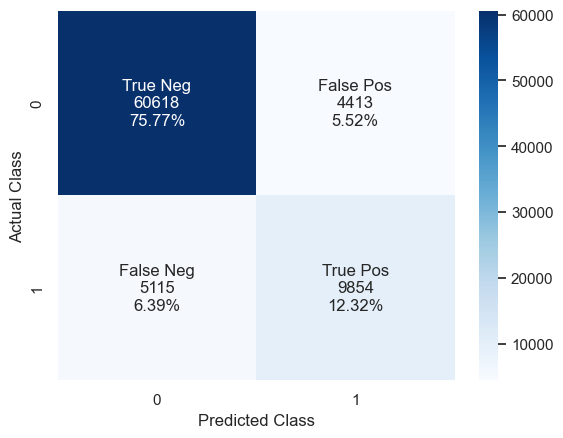

,Metric,Score
0,Accuracy,0.880900
1,Precision,0.878869
2,Recall,0.880900
3,F1 Score,0.879790
4,Log Loss,0.250865


In [42]:
evaluate_model(clf_cat, x_val, y_val)

In [43]:
param_dist = {
    'classifier__iterations': stats.randint(100, 1000),  # Number of boosting iterations
    'classifier__depth': stats.randint(3, 10),           # Depth of the trees
    'classifier__learning_rate': stats.uniform(0.01, 0.3), # Learning rate
    'classifier__l2_leaf_reg': stats.uniform(1, 10),     # L2 regularization term on weights
    'classifier__border_count': stats.randint(32, 255),  # Number of splits for features
    'classifier__bagging_temperature': stats.uniform(0, 1), # Controls the strength of the bagging
}

In [44]:
LogLoss = make_scorer(log_loss, greater_is_better=False, needs_proba=True)
random_search_cat = RandomizedSearchCV(
    clf_cat,  # The pipeline containing preprocessing and classification steps
    param_distributions=param_dist,  # The parameter grid for random sampling
    n_iter=10,  # Number of random parameter settings to try
    cv=3,  # Number of cross-validation folds
    scoring=LogLoss,  # Metric to evaluate the performance of the model
    n_jobs=-1,  # Use all available cores for computation
    verbose=1,  # Verbosity level, set to 1 to get progress updates
    random_state = 105
)

# Fit the RandomizedSearchCV object to the training data
# This will search for the best hyperparameters based on cross-validation performance
random_search_cat.fit(x_train, y_train)

# Extract the best parameters and score from the RandomizedSearchCV object
# These represent the combination of hyperparameters that resulted in the highest cross-validation score
best_params = random_search_cat.best_params_
best_score = random_search_cat.best_score_

# Print the best parameters and the corresponding cross-validation score
print("Best Parameters: ", best_params)
print("Best Cross-Validation Score: ", best_score)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
0:	learn: 0.6447310	total: 62.9ms	remaining: 56.1s
1:	learn: 0.6029979	total: 122ms	remaining: 54.2s
2:	learn: 0.5649557	total: 184ms	remaining: 54.5s
3:	learn: 0.5322607	total: 244ms	remaining: 54.3s
4:	learn: 0.5025113	total: 309ms	remaining: 55s
5:	learn: 0.4763713	total: 371ms	remaining: 54.8s
6:	learn: 0.4503988	total: 434ms	remaining: 54.9s
7:	learn: 0.4292326	total: 512ms	remaining: 56.7s
8:	learn: 0.4102706	total: 603ms	remaining: 59.3s
9:	learn: 0.3935931	total: 667ms	remaining: 58.9s
10:	learn: 0.3793681	total: 734ms	remaining: 58.9s
11:	learn: 0.3670494	total: 798ms	remaining: 58.6s
12:	learn: 0.3555437	total: 864ms	remaining: 58.5s
13:	learn: 0.3459174	total: 930ms	remaining: 58.4s
14:	learn: 0.3368780	total: 995ms	remaining: 58.2s
15:	learn: 0.3293124	total: 1.06s	remaining: 58.1s
16:	learn: 0.3227118	total: 1.12s	remaining: 57.9s
17:	learn: 0.3166972	total: 1.19s	remaining: 57.8s
18:	learn: 0.3114411	total: 1.25

162:	learn: 0.2530729	total: 10.4s	remaining: 46.6s
163:	learn: 0.2530546	total: 10.5s	remaining: 46.5s
164:	learn: 0.2530422	total: 10.5s	remaining: 46.5s
165:	learn: 0.2530273	total: 10.6s	remaining: 46.4s
166:	learn: 0.2530173	total: 10.7s	remaining: 46.3s
167:	learn: 0.2529954	total: 10.7s	remaining: 46.3s
168:	learn: 0.2529737	total: 10.8s	remaining: 46.2s
169:	learn: 0.2529556	total: 10.8s	remaining: 46.1s
170:	learn: 0.2529482	total: 10.9s	remaining: 46s
171:	learn: 0.2529371	total: 11s	remaining: 46s
172:	learn: 0.2529129	total: 11s	remaining: 45.9s
173:	learn: 0.2529030	total: 11.1s	remaining: 45.8s
174:	learn: 0.2528898	total: 11.1s	remaining: 45.7s
175:	learn: 0.2528785	total: 11.2s	remaining: 45.6s
176:	learn: 0.2528568	total: 11.3s	remaining: 45.6s
177:	learn: 0.2528437	total: 11.3s	remaining: 45.5s
178:	learn: 0.2528294	total: 11.4s	remaining: 45.4s
179:	learn: 0.2528143	total: 11.4s	remaining: 45.3s
180:	learn: 0.2528060	total: 11.5s	remaining: 45.3s
181:	learn: 0.252787

322:	learn: 0.2515054	total: 20.4s	remaining: 36s
323:	learn: 0.2514946	total: 20.5s	remaining: 36s
324:	learn: 0.2514858	total: 20.6s	remaining: 35.9s
325:	learn: 0.2514775	total: 20.6s	remaining: 35.8s
326:	learn: 0.2514734	total: 20.7s	remaining: 35.8s
327:	learn: 0.2514684	total: 20.7s	remaining: 35.7s
328:	learn: 0.2514631	total: 20.8s	remaining: 35.6s
329:	learn: 0.2514579	total: 20.8s	remaining: 35.6s
330:	learn: 0.2514459	total: 20.9s	remaining: 35.5s
331:	learn: 0.2514398	total: 21s	remaining: 35.4s
332:	learn: 0.2514350	total: 21s	remaining: 35.4s
333:	learn: 0.2514212	total: 21.1s	remaining: 35.3s
334:	learn: 0.2514150	total: 21.2s	remaining: 35.2s
335:	learn: 0.2514110	total: 21.2s	remaining: 35.2s
336:	learn: 0.2514036	total: 21.3s	remaining: 35.1s
337:	learn: 0.2513924	total: 21.3s	remaining: 35s
338:	learn: 0.2513828	total: 21.4s	remaining: 35s
339:	learn: 0.2513782	total: 21.5s	remaining: 34.9s
340:	learn: 0.2513705	total: 21.5s	remaining: 34.8s
341:	learn: 0.2513634	to

482:	learn: 0.2503374	total: 30.1s	remaining: 25.5s
483:	learn: 0.2503285	total: 30.1s	remaining: 25.5s
484:	learn: 0.2503223	total: 30.2s	remaining: 25.4s
485:	learn: 0.2503173	total: 30.3s	remaining: 25.3s
486:	learn: 0.2503127	total: 30.3s	remaining: 25.3s
487:	learn: 0.2503050	total: 30.4s	remaining: 25.2s
488:	learn: 0.2502985	total: 30.4s	remaining: 25.1s
489:	learn: 0.2502830	total: 30.5s	remaining: 25.1s
490:	learn: 0.2502764	total: 30.6s	remaining: 25s
491:	learn: 0.2502720	total: 30.6s	remaining: 25s
492:	learn: 0.2502627	total: 30.7s	remaining: 24.9s
493:	learn: 0.2502565	total: 30.7s	remaining: 24.8s
494:	learn: 0.2502492	total: 30.8s	remaining: 24.8s
495:	learn: 0.2502407	total: 30.9s	remaining: 24.7s
496:	learn: 0.2502329	total: 30.9s	remaining: 24.6s
497:	learn: 0.2502251	total: 31s	remaining: 24.6s
498:	learn: 0.2502167	total: 31s	remaining: 24.5s
499:	learn: 0.2502106	total: 31.1s	remaining: 24.4s
500:	learn: 0.2502039	total: 31.2s	remaining: 24.4s
501:	learn: 0.250195

642:	learn: 0.2493198	total: 41.3s	remaining: 16s
643:	learn: 0.2493187	total: 41.3s	remaining: 16s
644:	learn: 0.2493121	total: 41.4s	remaining: 15.9s
645:	learn: 0.2493061	total: 41.5s	remaining: 15.9s
646:	learn: 0.2493023	total: 41.6s	remaining: 15.8s
647:	learn: 0.2492969	total: 41.7s	remaining: 15.8s
648:	learn: 0.2492865	total: 41.7s	remaining: 15.7s
649:	learn: 0.2492851	total: 41.8s	remaining: 15.6s
650:	learn: 0.2492812	total: 41.9s	remaining: 15.6s
651:	learn: 0.2492787	total: 42s	remaining: 15.5s
652:	learn: 0.2492725	total: 42s	remaining: 15.5s
653:	learn: 0.2492698	total: 42.1s	remaining: 15.4s
654:	learn: 0.2492659	total: 42.2s	remaining: 15.3s
655:	learn: 0.2492650	total: 42.3s	remaining: 15.3s
656:	learn: 0.2492601	total: 42.4s	remaining: 15.2s
657:	learn: 0.2492550	total: 42.4s	remaining: 15.2s
658:	learn: 0.2492509	total: 42.5s	remaining: 15.1s
659:	learn: 0.2492484	total: 42.6s	remaining: 15s
660:	learn: 0.2492446	total: 42.7s	remaining: 15s
661:	learn: 0.2492376	to

801:	learn: 0.2484173	total: 54s	remaining: 6.13s
802:	learn: 0.2484110	total: 54.1s	remaining: 6.06s
803:	learn: 0.2484098	total: 54.1s	remaining: 5.99s
804:	learn: 0.2484071	total: 54.2s	remaining: 5.93s
805:	learn: 0.2484036	total: 54.3s	remaining: 5.86s
806:	learn: 0.2483976	total: 54.4s	remaining: 5.8s
807:	learn: 0.2483919	total: 54.5s	remaining: 5.73s
808:	learn: 0.2483858	total: 54.5s	remaining: 5.66s
809:	learn: 0.2483794	total: 54.6s	remaining: 5.6s
810:	learn: 0.2483703	total: 54.7s	remaining: 5.53s
811:	learn: 0.2483666	total: 54.8s	remaining: 5.46s
812:	learn: 0.2483612	total: 54.9s	remaining: 5.4s
813:	learn: 0.2483555	total: 55s	remaining: 5.33s
814:	learn: 0.2483477	total: 55s	remaining: 5.27s
815:	learn: 0.2483418	total: 55.1s	remaining: 5.2s
816:	learn: 0.2483393	total: 55.2s	remaining: 5.13s
817:	learn: 0.2483364	total: 55.3s	remaining: 5.07s
818:	learn: 0.2483301	total: 55.4s	remaining: 5s
819:	learn: 0.2483244	total: 55.4s	remaining: 4.93s
820:	learn: 0.2483195	tot

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.93      0.93     65031
           1       0.69      0.66      0.67     14969

    accuracy                           0.88     80000
   macro avg       0.81      0.80      0.80     80000
weighted avg       0.88      0.88      0.88     80000



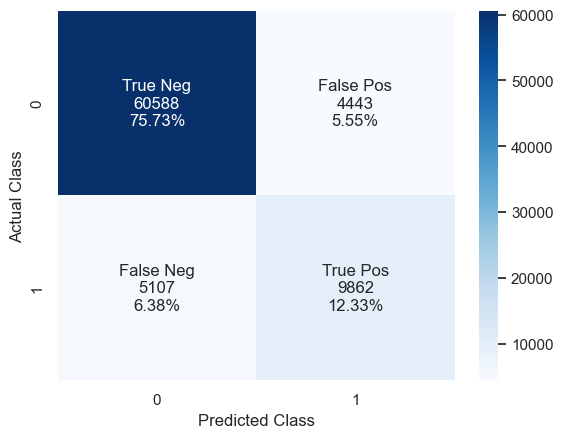

,Metric,Score
0,Accuracy,0.880625
1,Precision,0.878692
2,Recall,0.880625
3,F1 Score,0.879574
4,Log Loss,0.250100


In [45]:
# Evaluating the model on the validation set
evaluate_model(random_search_cat, x_val, y_val)

In [46]:
# Creating a new pipeline to train the tuned model on a combination of the training and validation set
best_cat = random_search_cat.best_estimator_
best_cat.fit((pd.concat((x_train, x_val))), pd.concat((y_train, y_val)))

0:	learn: 0.6443622	total: 94.4ms	remaining: 1m 24s
1:	learn: 0.6025378	total: 193ms	remaining: 1m 26s
2:	learn: 0.5646109	total: 306ms	remaining: 1m 30s
3:	learn: 0.5317653	total: 442ms	remaining: 1m 38s
4:	learn: 0.5004500	total: 552ms	remaining: 1m 38s
5:	learn: 0.4732759	total: 651ms	remaining: 1m 36s
6:	learn: 0.4484371	total: 744ms	remaining: 1m 34s
7:	learn: 0.4285362	total: 837ms	remaining: 1m 32s
8:	learn: 0.4099948	total: 925ms	remaining: 1m 30s
9:	learn: 0.3944292	total: 1.01s	remaining: 1m 29s
10:	learn: 0.3803211	total: 1.13s	remaining: 1m 30s
11:	learn: 0.3677627	total: 1.25s	remaining: 1m 31s
12:	learn: 0.3566999	total: 1.35s	remaining: 1m 31s
13:	learn: 0.3469962	total: 1.44s	remaining: 1m 30s
14:	learn: 0.3374933	total: 1.54s	remaining: 1m 29s
15:	learn: 0.3297443	total: 1.63s	remaining: 1m 29s
16:	learn: 0.3230185	total: 1.72s	remaining: 1m 28s
17:	learn: 0.3163773	total: 1.81s	remaining: 1m 28s
18:	learn: 0.3111540	total: 1.91s	remaining: 1m 27s
19:	learn: 0.3063670	

159:	learn: 0.2524631	total: 16.7s	remaining: 1m 16s
160:	learn: 0.2524437	total: 16.8s	remaining: 1m 16s
161:	learn: 0.2524351	total: 16.9s	remaining: 1m 16s
162:	learn: 0.2524149	total: 17s	remaining: 1m 16s
163:	learn: 0.2524117	total: 17.1s	remaining: 1m 15s
164:	learn: 0.2523979	total: 17.2s	remaining: 1m 15s
165:	learn: 0.2523873	total: 17.3s	remaining: 1m 15s
166:	learn: 0.2523722	total: 17.4s	remaining: 1m 15s
167:	learn: 0.2523600	total: 17.6s	remaining: 1m 15s
168:	learn: 0.2523514	total: 17.7s	remaining: 1m 15s
169:	learn: 0.2523308	total: 17.8s	remaining: 1m 15s
170:	learn: 0.2523211	total: 17.9s	remaining: 1m 15s
171:	learn: 0.2523118	total: 18s	remaining: 1m 15s
172:	learn: 0.2523055	total: 18.1s	remaining: 1m 15s
173:	learn: 0.2522894	total: 18.3s	remaining: 1m 15s
174:	learn: 0.2522745	total: 18.4s	remaining: 1m 15s
175:	learn: 0.2522573	total: 18.5s	remaining: 1m 15s
176:	learn: 0.2522474	total: 18.6s	remaining: 1m 15s
177:	learn: 0.2522337	total: 18.7s	remaining: 1m 1

316:	learn: 0.2511597	total: 34.9s	remaining: 1m 3s
317:	learn: 0.2511568	total: 35s	remaining: 1m 3s
318:	learn: 0.2511500	total: 35.1s	remaining: 1m 3s
319:	learn: 0.2511415	total: 35.2s	remaining: 1m 3s
320:	learn: 0.2511322	total: 35.4s	remaining: 1m 3s
321:	learn: 0.2511271	total: 35.5s	remaining: 1m 2s
322:	learn: 0.2511227	total: 35.6s	remaining: 1m 2s
323:	learn: 0.2511190	total: 35.8s	remaining: 1m 2s
324:	learn: 0.2511123	total: 35.9s	remaining: 1m 2s
325:	learn: 0.2511081	total: 36s	remaining: 1m 2s
326:	learn: 0.2510963	total: 36.2s	remaining: 1m 2s
327:	learn: 0.2510891	total: 36.3s	remaining: 1m 2s
328:	learn: 0.2510776	total: 36.4s	remaining: 1m 2s
329:	learn: 0.2510759	total: 36.6s	remaining: 1m 2s
330:	learn: 0.2510662	total: 36.7s	remaining: 1m 2s
331:	learn: 0.2510634	total: 36.8s	remaining: 1m 2s
332:	learn: 0.2510562	total: 36.9s	remaining: 1m 2s
333:	learn: 0.2510536	total: 37s	remaining: 1m 2s
334:	learn: 0.2510485	total: 37.2s	remaining: 1m 1s
335:	learn: 0.2510

477:	learn: 0.2501033	total: 54.3s	remaining: 47.1s
478:	learn: 0.2500981	total: 54.4s	remaining: 47s
479:	learn: 0.2500903	total: 54.5s	remaining: 46.9s
480:	learn: 0.2500864	total: 54.6s	remaining: 46.8s
481:	learn: 0.2500800	total: 54.8s	remaining: 46.7s
482:	learn: 0.2500735	total: 54.9s	remaining: 46.6s
483:	learn: 0.2500676	total: 55s	remaining: 46.5s
484:	learn: 0.2500617	total: 55.2s	remaining: 46.4s
485:	learn: 0.2500560	total: 55.3s	remaining: 46.3s
486:	learn: 0.2500455	total: 55.4s	remaining: 46.2s
487:	learn: 0.2500425	total: 55.5s	remaining: 46.1s
488:	learn: 0.2500350	total: 55.6s	remaining: 46s
489:	learn: 0.2500251	total: 55.8s	remaining: 45.9s
490:	learn: 0.2500217	total: 55.9s	remaining: 45.7s
491:	learn: 0.2500159	total: 56s	remaining: 45.6s
492:	learn: 0.2500094	total: 56.1s	remaining: 45.5s
493:	learn: 0.2500057	total: 56.2s	remaining: 45.4s
494:	learn: 0.2499995	total: 56.3s	remaining: 45.3s
495:	learn: 0.2499932	total: 56.4s	remaining: 45.2s
496:	learn: 0.249983

636:	learn: 0.2492109	total: 1m 13s	remaining: 29.4s
637:	learn: 0.2492075	total: 1m 13s	remaining: 29.3s
638:	learn: 0.2491979	total: 1m 13s	remaining: 29.1s
639:	learn: 0.2491928	total: 1m 13s	remaining: 29s
640:	learn: 0.2491912	total: 1m 13s	remaining: 28.9s
641:	learn: 0.2491840	total: 1m 13s	remaining: 28.8s
642:	learn: 0.2491753	total: 1m 13s	remaining: 28.7s
643:	learn: 0.2491742	total: 1m 13s	remaining: 28.6s
644:	learn: 0.2491702	total: 1m 13s	remaining: 28.4s
645:	learn: 0.2491635	total: 1m 14s	remaining: 28.3s
646:	learn: 0.2491565	total: 1m 14s	remaining: 28.2s
647:	learn: 0.2491513	total: 1m 14s	remaining: 28.1s
648:	learn: 0.2491471	total: 1m 14s	remaining: 27.9s
649:	learn: 0.2491397	total: 1m 14s	remaining: 27.8s
650:	learn: 0.2491366	total: 1m 14s	remaining: 27.7s
651:	learn: 0.2491292	total: 1m 14s	remaining: 27.6s
652:	learn: 0.2491249	total: 1m 14s	remaining: 27.4s
653:	learn: 0.2491219	total: 1m 14s	remaining: 27.3s
654:	learn: 0.2491179	total: 1m 14s	remaining: 2

794:	learn: 0.2484382	total: 1m 29s	remaining: 11s
795:	learn: 0.2484323	total: 1m 29s	remaining: 10.9s
796:	learn: 0.2484279	total: 1m 29s	remaining: 10.8s
797:	learn: 0.2484243	total: 1m 29s	remaining: 10.6s
798:	learn: 0.2484222	total: 1m 29s	remaining: 10.5s
799:	learn: 0.2484209	total: 1m 29s	remaining: 10.4s
800:	learn: 0.2484096	total: 1m 29s	remaining: 10.3s
801:	learn: 0.2484068	total: 1m 29s	remaining: 10.2s
802:	learn: 0.2484009	total: 1m 29s	remaining: 10.1s
803:	learn: 0.2483937	total: 1m 30s	remaining: 9.96s
804:	learn: 0.2483906	total: 1m 30s	remaining: 9.85s
805:	learn: 0.2483858	total: 1m 30s	remaining: 9.73s
806:	learn: 0.2483814	total: 1m 30s	remaining: 9.62s
807:	learn: 0.2483766	total: 1m 30s	remaining: 9.51s
808:	learn: 0.2483721	total: 1m 30s	remaining: 9.39s
809:	learn: 0.2483685	total: 1m 30s	remaining: 9.28s
810:	learn: 0.2483624	total: 1m 30s	remaining: 9.17s
811:	learn: 0.2483593	total: 1m 30s	remaining: 9.06s
812:	learn: 0.2483533	total: 1m 30s	remaining: 8

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['MONTANT', 'FREQUENCE_RECH',
                                                   'REVENUE', 'ARPU_SEGMENT',
                                                   'FREQUENCE', 'DATA_VOLUME',
                                                   'ON_NET', 'ORANGE', 'TIGO',
                                                   'REGULARITY']),
                                                 ('cat',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['REGION', 'TENURE', 'TOP_PACK'], dtype='object'))])),
                ('classifier',
                 <catboost.core.CatBoostClassifier object at 0x0000017C2208C310>)])

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.93      0.93     65031
           1       0.69      0.64      0.67     14969

    accuracy                           0.88     80000
   macro avg       0.80      0.79      0.80     80000
weighted avg       0.88      0.88      0.88     80000



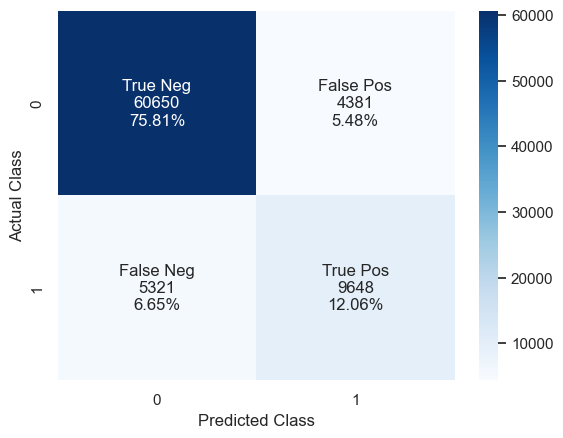

,Metric,Score
0,Accuracy,0.878725
1,Precision,0.876003
2,Recall,0.878725
3,F1 Score,0.877194
4,Log Loss,0.251399


In [47]:
#Evaluating the new model on the test set
evaluate_model(best_cat, x_test, y_test)

In [48]:
## Making Predictions on Test Data
# Finally, we use the trained model to make predictions on the test set and prepare the submission file.
predictions = best_cat.predict_proba(test)[:, 1]

baseline_sub = sample_sub.copy()
baseline_sub['CHURN'] = predictions
baseline_sub.to_csv('submission_cat_num_expresso.csv', index=False)

# # Display the first few rows of the submission file
baseline_sub.head()

,user_id,CHURN
0,af900d87e73b7ff6509d2203df4704a98aa5f2a6,0.783115
1,5335efd940280b82143272275637d1e65d37eadb,0.667221
2,a581f4fa08677c26f83f643248c667e241043086,0.122356
3,64f67177d0775262b8087a9e2e3b8061b6324ae6,0.001265
4,0d6009a4594c4be22449b8d9cc01a0bcea98faea,0.000111
